In [3]:
!nvidia-smi

In [4]:
from google.colab import drive
drive.mount('/content/drive')

## Install RAPIDS

In [ ]:
# セル実行後、リスタートされる
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

In [ ]:
# セル実行後、リスタートされる
import condacolab
condacolab.install()

In [ ]:
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

## Install Packages

In [6]:
!apt-get install mecab mecab-ipadic-utf8 libmecab-dev swig -y -qq
!pip install mecab-python3==0.996.2 japanize-matplotlib==1.1.3 -q   
!pip install fugashi==1.1.0 ipadic==1.0.0 transformers==4.10.0 -q
!pip install janome==0.4.1 sumeval==0.2.2 -q

## Download Japanese Fonts for Visualization

In [ ]:
cd /content/drive/MyDrive/grammer_correction_pytorch_lightning/data/

In [ ]:
!curl -L 'https://moji.or.jp/wp-content/ipafont/IPAexfont/ipaexg00401.zip' -o ipaexg00401.zip
!unzip ipaexg00401.zip && rm ipaexg00401.zip

## Download Dataset

In [8]:
cd /content/drive/MyDrive/grammer_correction_pytorch_lightning/data/japanese-wikipedia-grammer-correct-dataset

In [21]:
!curl -L 'https://nlp.ist.i.kyoto-u.ac.jp/DLcounter/lime.cgi?down=https://nlp.ist.i.kyoto-u.ac.jp/nl-resource/JWTD/jwtd_v2.0.tar.gz&name=JWTDv2.0.tar.gz' -o JWTDv2.0.tar.gz
!tar zxvf JWTDv2.0.tar.gz && rm JWTDv2.0.tar.gz

## Import Libraries

In [9]:
import gc
import MeCab
import warnings
import unicodedata
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import japanize_matplotlib
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from cuml import PCA, TSNE, UMAP
from sumeval.metrics.rouge import RougeCalculator
import torch
from transformers import BertJapaneseTokenizer, BertModel
from tqdm.notebook import tqdm

pd.set_option('display.max_colwidth', 10000)
warnings.simplefilter('ignore')

In [10]:
class Cfg:
  seed = 42
  model_name = 'cl-tohoku/bert-base-japanese-whole-word-masking'
  max_length = 64
  extract_feats = ['名詞', '形容詞']
  font_path = '../ipaexg00401/ipaexg.ttf'
  stopwords_libpath = 'http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt'
  categories = ['kanji-conversion_a', 'kanji-conversion_b', 'insertion_a', 'insertion_b', 'deletion', 'substitution', 'transposition', 'others']
  extract_categories = [['kanji-conversion_a','kanji-conversion_b'], 'substitution']

In [22]:
# train/test/goldとあるが、goldは使用しない
train = pd.read_json('jwtd_v2.0/train.jsonl', orient='records', lines=True)
test = pd.read_json('jwtd_v2.0/test.jsonl', orient='records', lines=True)

In [23]:
display(train.head(1))
display(test.head(1))

page  ... lstm_average_likelihood
0    10  ...                    -3.0

[1 rows x 8 columns]

page  ... lstm_average_likelihood
0   239  ...                   -3.26

[1 rows x 8 columns]

In [24]:
# diffsカラムを元に、categoryカラムを作成
train['category'] = [train.diffs.iloc[i][0]['category'] for i in range(len(train))]
test['category'] = [test.diffs.iloc[i][0]['category'] for i in range(len(test))]

#### タスク別

・kanji-conversion (漢字誤変換) (_a, _bが混在)

In [44]:
display(train.query('category == "kanji-conversion_a"').head(1))

page title  ...  lstm_average_likelihood            category
0    10    言語  ...                     -3.0  kanji-conversion_a

[1 rows x 9 columns]

・substitution (誤字)

In [30]:
display(train.query('category == "substitution"').head(1))

page title  ...  lstm_average_likelihood      category
8    11   日本語  ...                    -3.45  substitution

[1 rows x 9 columns]

・deletion (脱字)

In [31]:
display(train.query('category == "deletion"').head(1))

page title  ...  lstm_average_likelihood  category
2    10    言語  ...                    -2.86  deletion

[1 rows x 9 columns]

・insertion (衍字) (_a, _bが混在)

In [32]:
display(train.query('category == "insertion_a"').head(1))

page title  ...  lstm_average_likelihood     category
1    10    言語  ...                    -2.73  insertion_a

[1 rows x 9 columns]

・transposition (転置)

下の例では、「ん」と「っ」が入れ替わっている

In [36]:
display(train.query('category == "transposition"').head(1))

page title  ...  lstm_average_likelihood       category
11    11   日本語  ...                     -3.7  transposition

[1 rows x 9 columns]

・others

In [38]:
display(train.query('category == "others"').head(1))

page title  ...  lstm_average_likelihood  category
3    10    言語  ...                    -2.87    others

[1 rows x 9 columns]

## EDA

In [ ]:
print(f'訓練データのpre_textの文字数統計量 \n {train.pre_text.apply(lambda x: len(x)).describe()}\n')
print(f'訓練データのpost_textの文字数統計量 \n {train.post_text.apply(lambda x: len(x)).describe()}')
print()
print(f'テストデータのpre_textの文字数統計量 \n {test.pre_text.apply(lambda x: len(x)).describe()}\n')
print(f'テストデータのpost_textの文字数統計量 \n {test.post_text.apply(lambda x: len(x)).describe()}')

訓練データのpre_textの文字数統計量 
 count    696189.000000
mean         59.914472
std          34.372743
min           8.000000
25%          35.000000
50%          53.000000
75%          77.000000
max         204.000000
Name: pre_text, dtype: float64

訓練データのpost_textの文字数統計量 
 count    696189.000000
mean         59.867767
std          34.358810
min          10.000000
25%          35.000000
50%          53.000000
75%          77.000000
max         200.000000
Name: post_text, dtype: float64

テストデータのpre_textの文字数統計量 
 count    5440.000000
mean       61.657537
std        34.709942
min         9.000000
25%        36.000000
50%        54.000000
75%        80.000000
max       200.000000
Name: pre_text, dtype: float64

テストデータのpost_textの文字数統計量 
 count    5440.000000
mean       61.559191
std        34.695865
min        10.000000
25%        36.000000
50%        54.000000
75%        80.000000
max       200.000000
Name: post_text, dtype: float64


In [ ]:
class CustomMeCabTagger(MeCab.Tagger):
    def __init__(self, extract_feats=None):
        super().__init__()
        self.extract_feats = extract_feats

    def parse_to_series(self, series):
        results = []
        texts = ' '.join(series.tolist())
        for sentence in texts.split('。'):
            parsed = self.parse(sentence)
            for line in parsed.split('\n'):
                try:
                    text, feature = line.split('\t')
                except ValueError:
                    pass
                feature = [None if f == '*' else f for f in feature.split(',')][0]
                if isinstance(self.extract_feats, list):
                    if feature in self.extract_feats:
                        results.append(text)
                else:
                    results.append(text)
        return pd.Series(results, name=series.name)

    def parse_to_string(self, series):
        results = []
        texts = ' '.join(series.tolist())
        for sentence in texts.split('。'):
            parsed = self.parse(sentence)
            for line in parsed.split('\n'):
                try:
                    text, feature = line.split('\t')
                except ValueError:
                    pass
                feature = [None if f == '*' else f for f in feature.split(',')][0]
                if isinstance(self.extract_feats, list):
                    if feature in self.extract_feats:
                        results.append(text)
                else:
                    results.append(text)
        return ' '.join(results)


class Ja_StopWords(object):
    def __init__(self, libpath):
        self.libpath = libpath

    def apply_stopwords_series(self, series):
        libfile = urllib.request.urlopen(self.libpath)
        lib_stopwords = [line.decode('utf-8').strip() for line in libfile]
        lib_stopwords = [stopwords for stopwords in lib_stopwords if not stopwords == u'']
        lib_stopwords = list(set(lib_stopwords))        
        series = pd.Series(
            [value for value in series if value not in lib_stopwords if not value.isdigit()], 
            name=series.name
            )
        return series    

    def apply_stopwords_string(self, text):
        libfile = urllib.request.urlopen(self.libpath)
        lib_stopwords = [line.decode('utf-8').strip() for line in libfile]
        lib_stopwords = [stopwords for stopwords in lib_stopwords if not stopwords == u'']
        lib_stopwords = list(set(lib_stopwords))        
        text = ' '.join([word for word in text.split(' ') if word not in lib_stopwords if not word.isdigit()])
        return text

In [ ]:
tagger = CustomMeCabTagger(Cfg.extract_feats)
stopwords = Ja_StopWords(Cfg.stopwords_libpath)

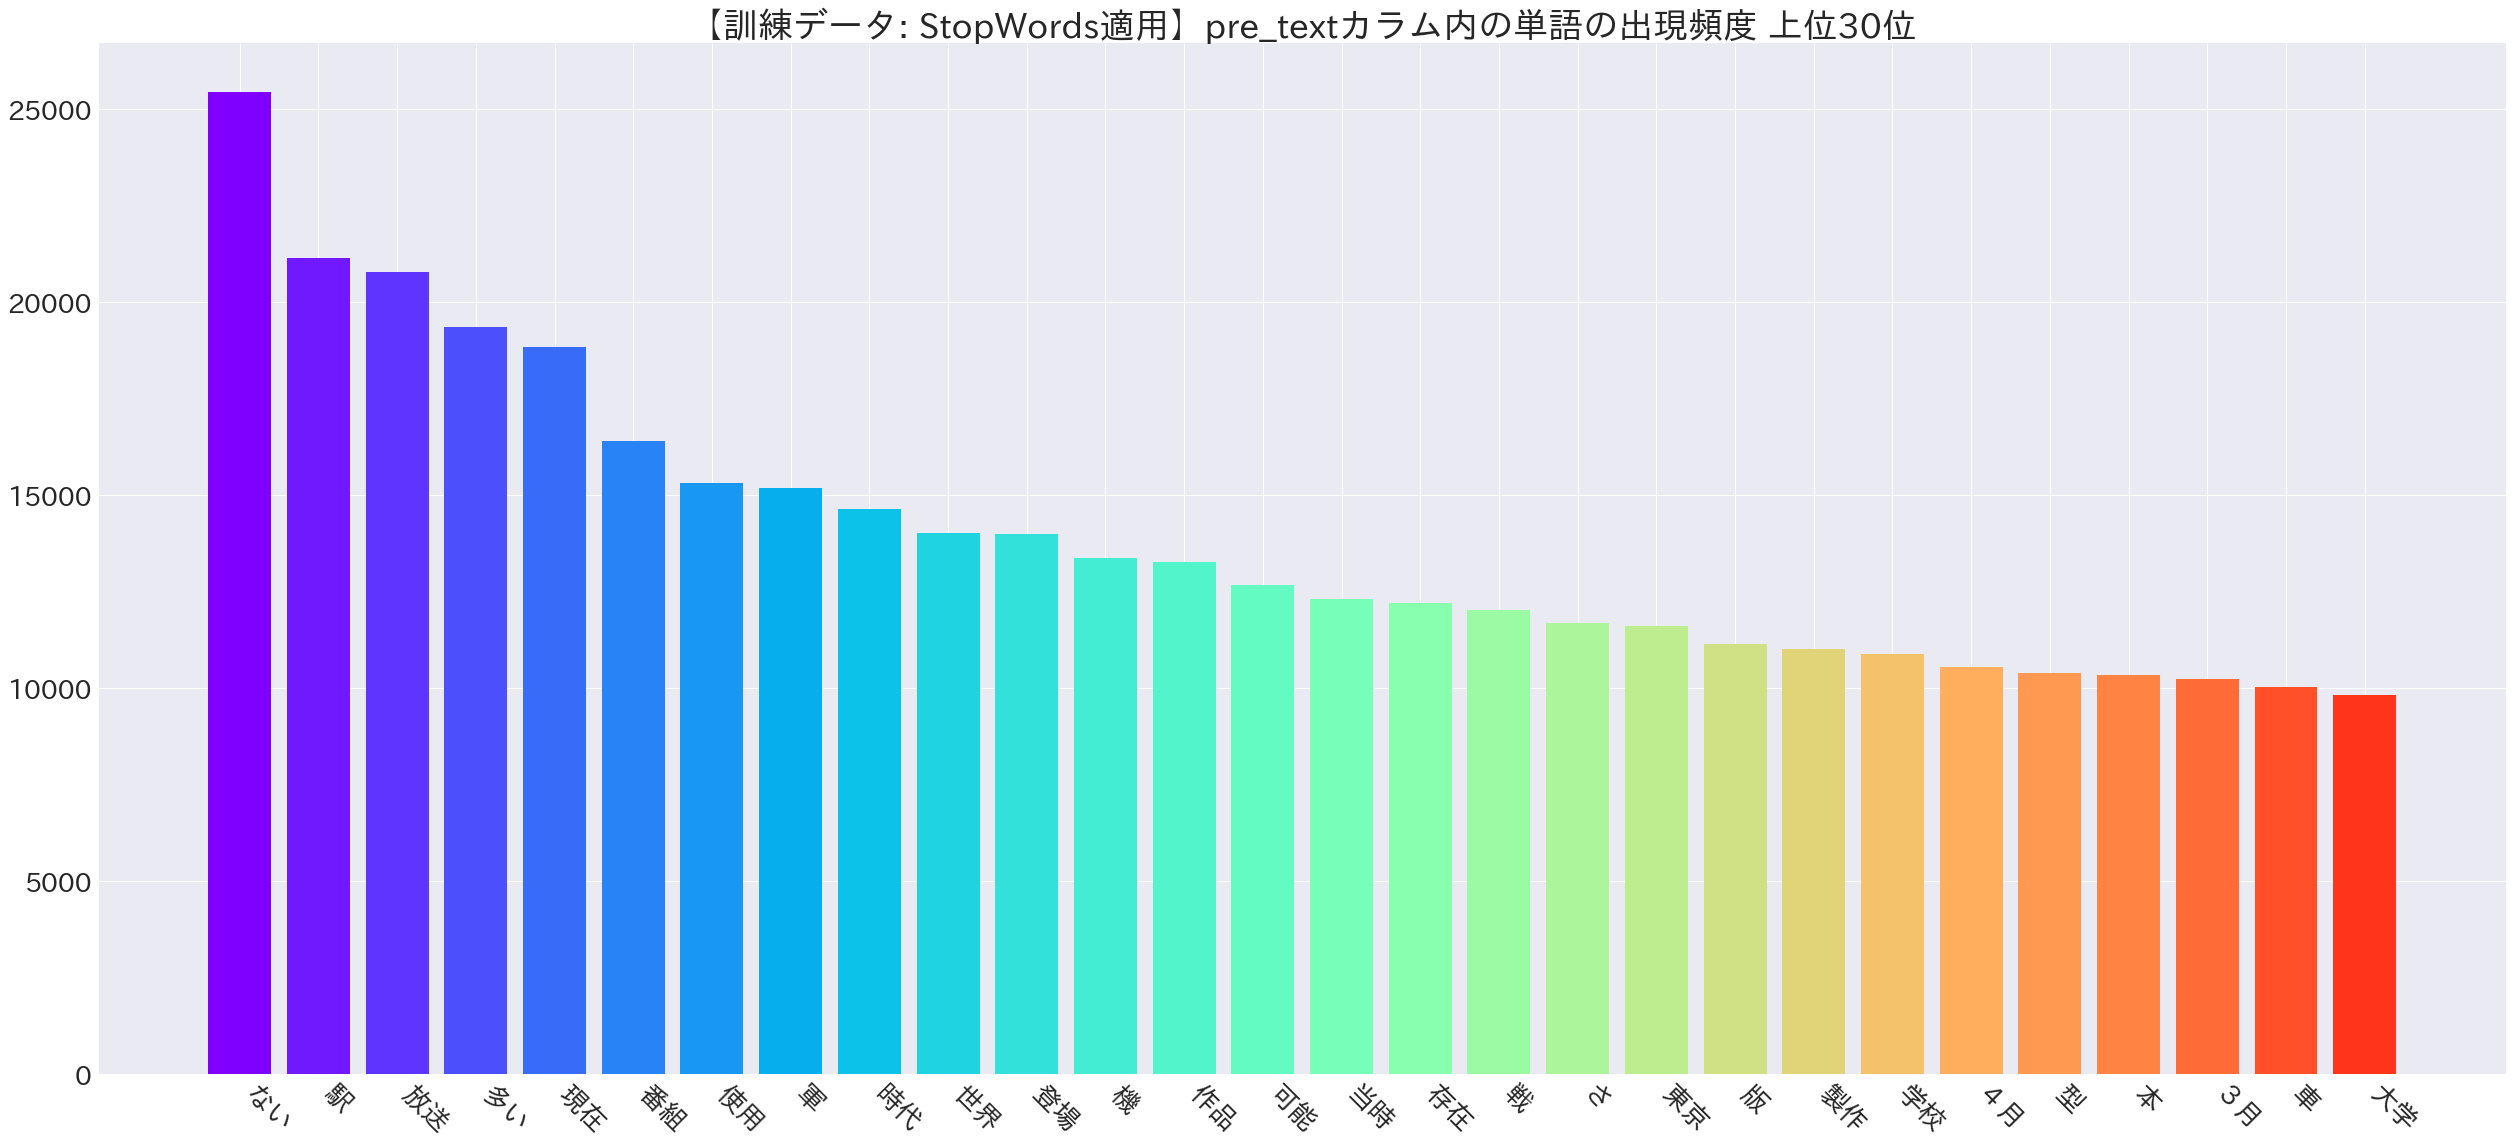

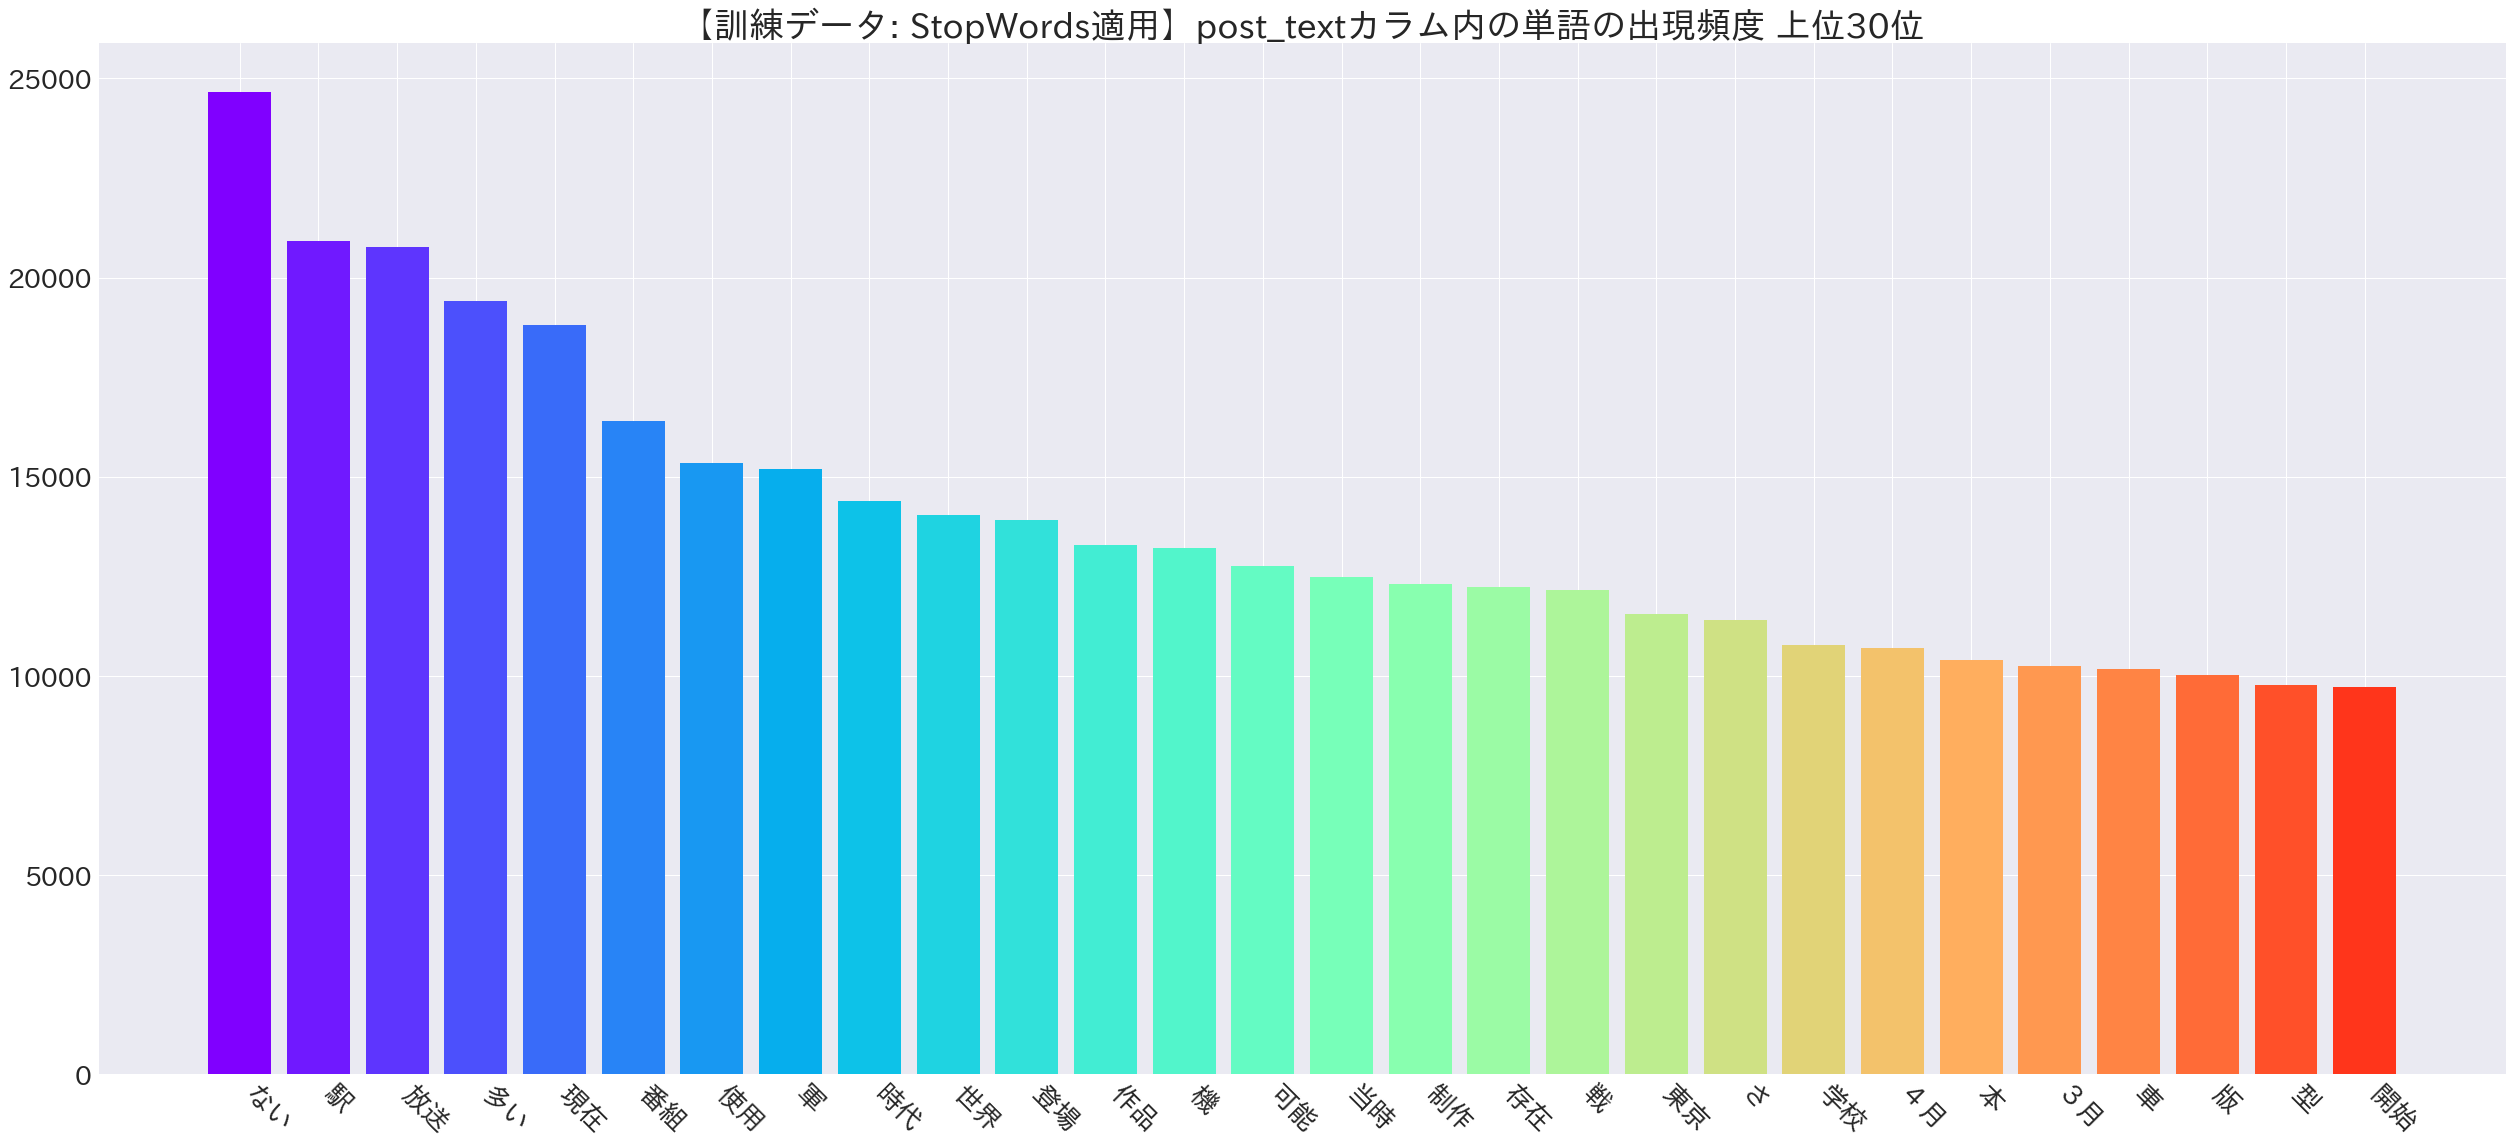

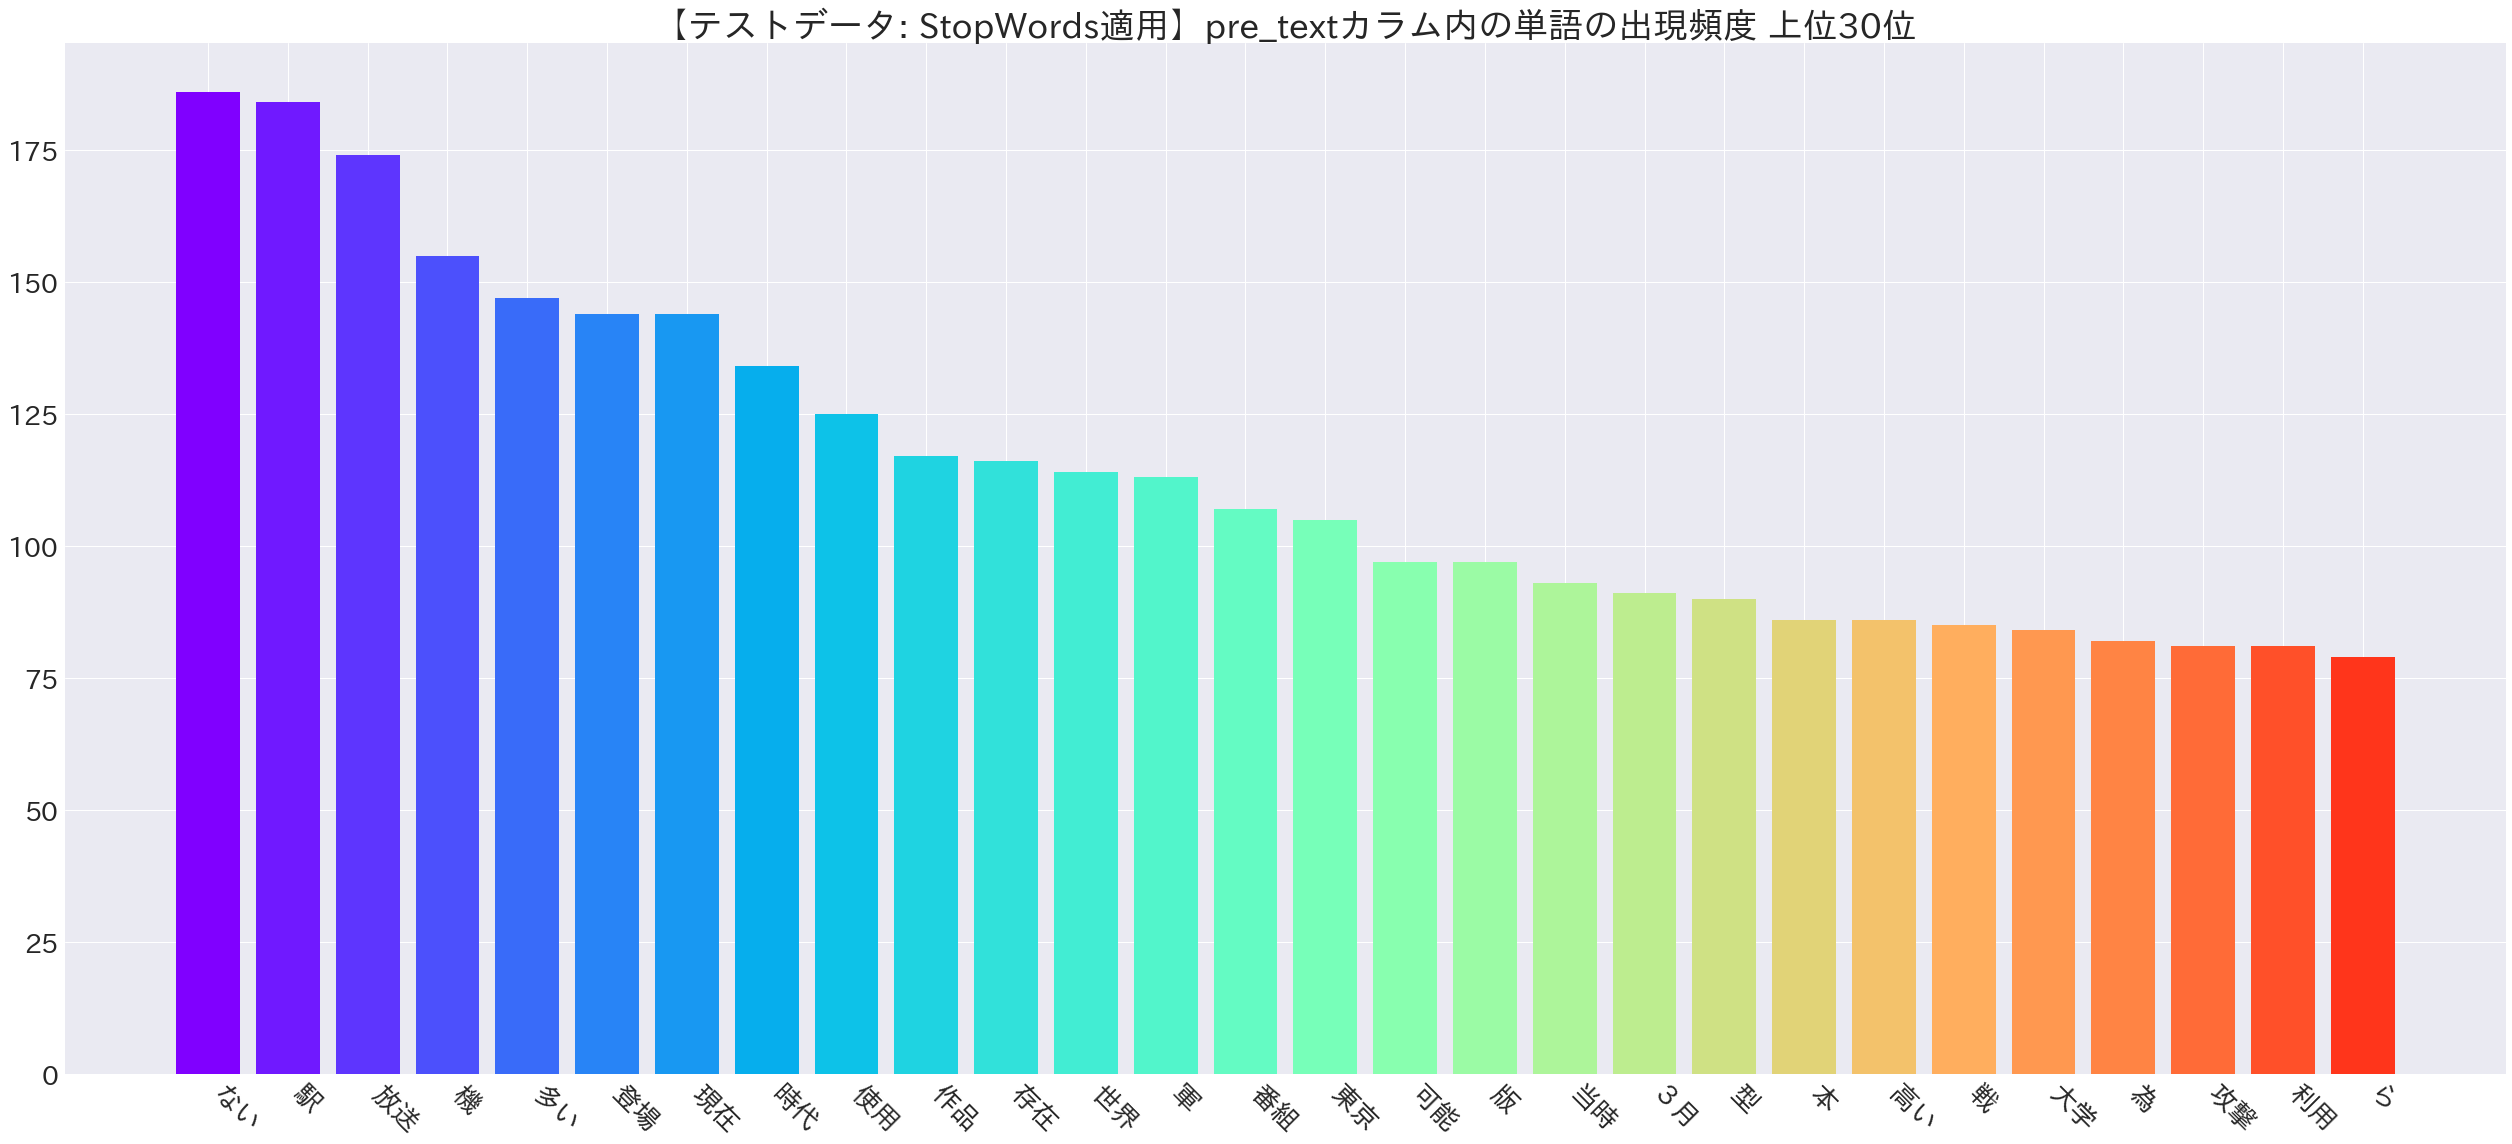

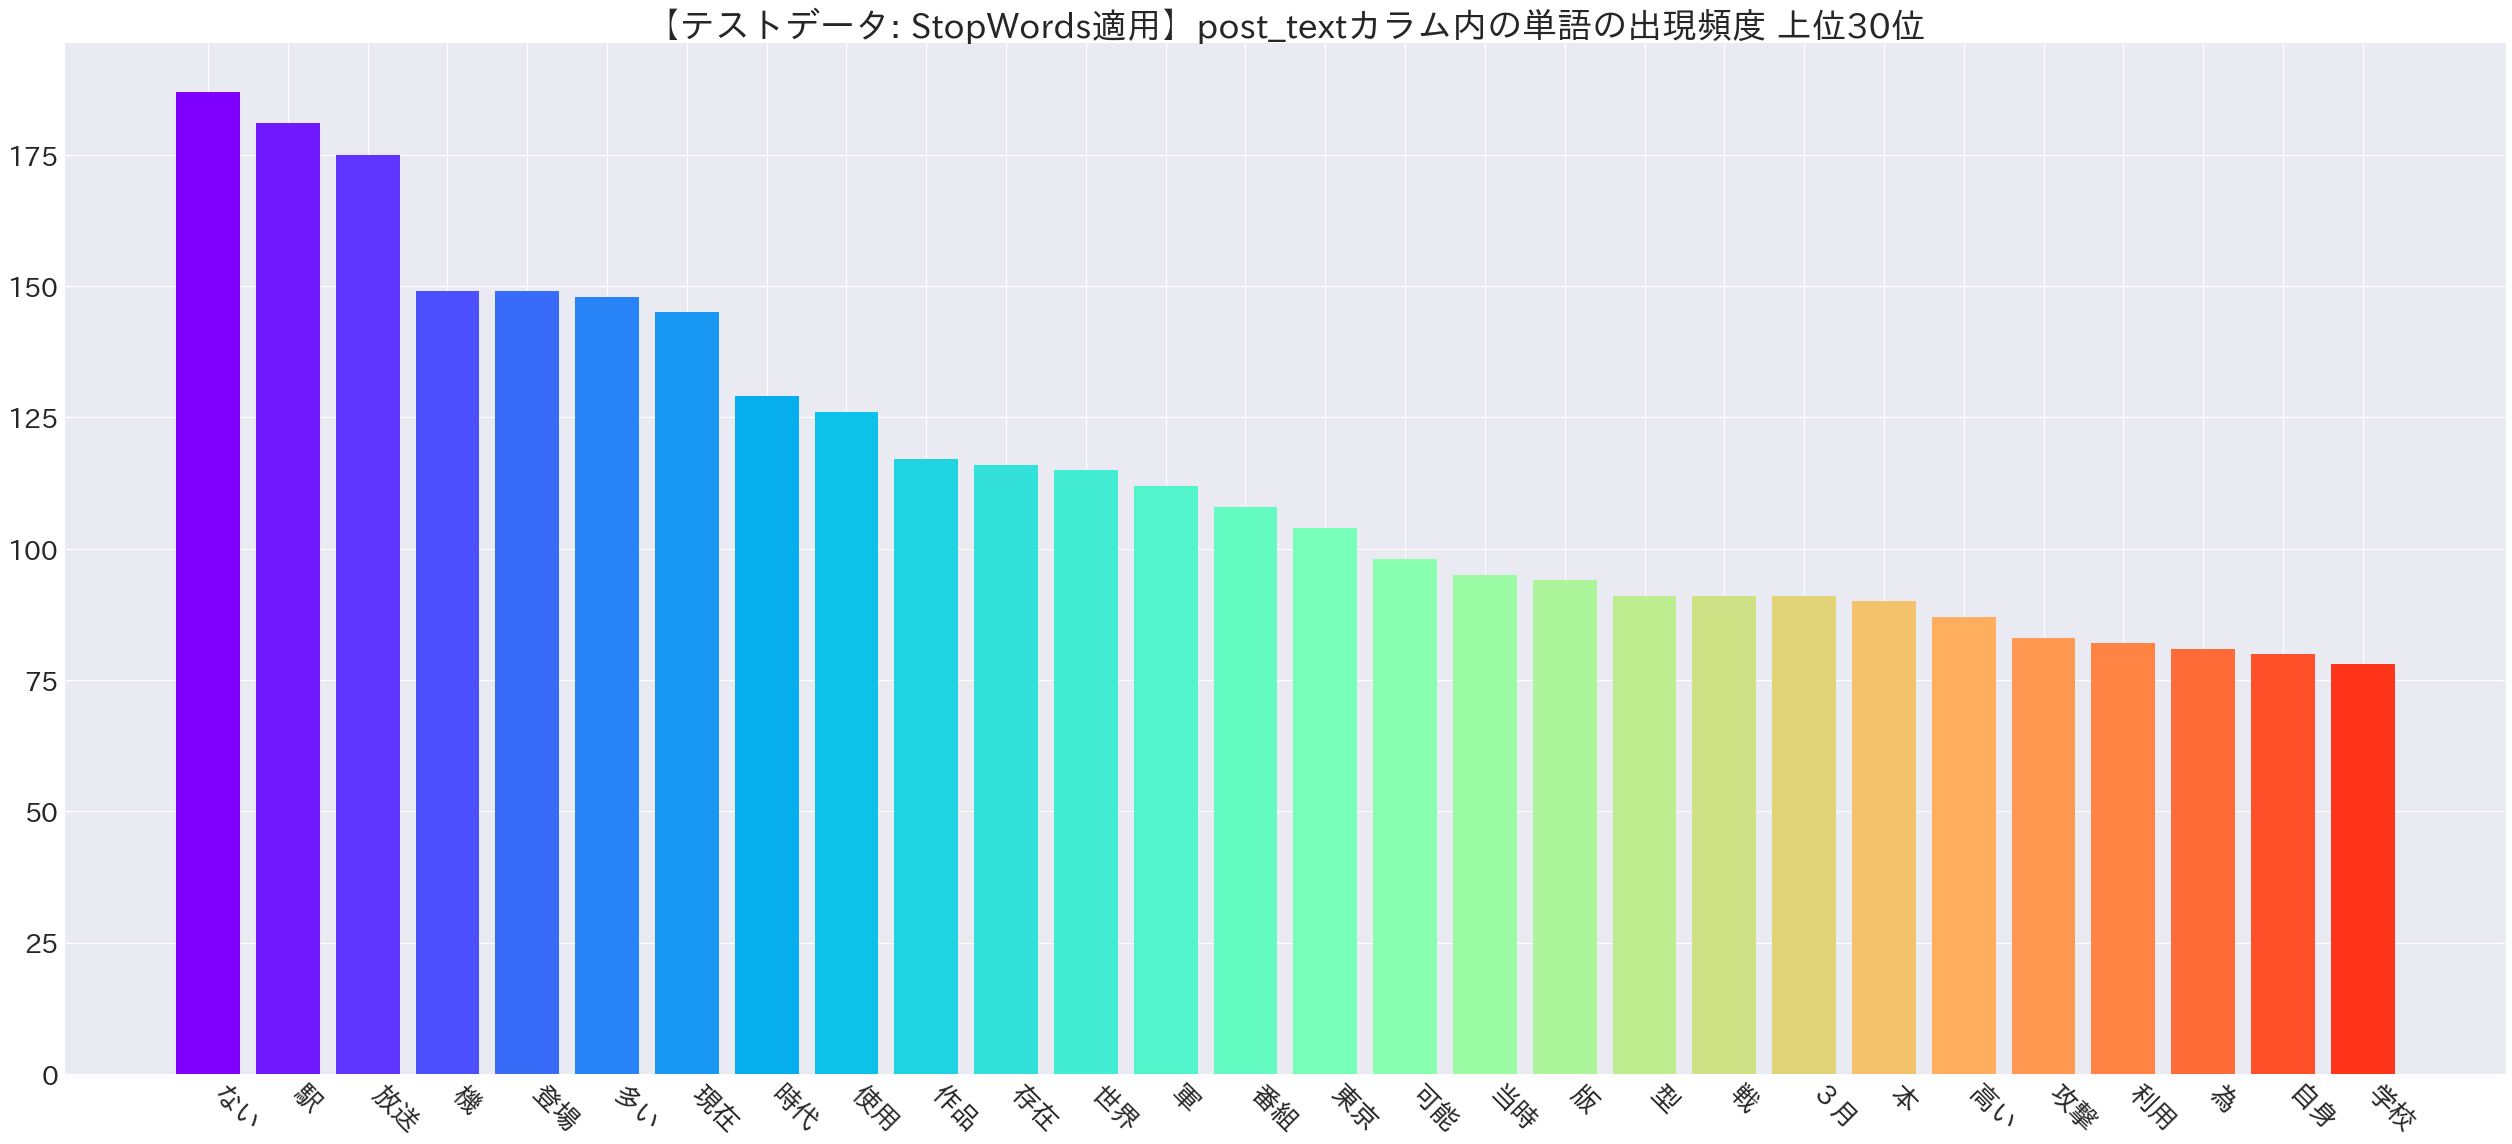

In [ ]:
def bar_plot(word_counts, title):
    plt.style.use('seaborn')
    japanize_matplotlib.japanize()
    fig = plt.figure(figsize=(35,16))
    bar_colors = cm.rainbow(np.linspace(0,1,30))
    plt.bar(word_counts.index.values[2:30], word_counts.values[2:30], color=bar_colors, linewidth=0)
    plt.tick_params(labelsize=27)
    plt.xticks(rotation=-45, ha='left')
    plt.title(title, fontsize=35) 
    plt.tight_layout()

bar_plot(stopwords.apply_stopwords_series(tagger.parse_to_series(train.pre_text)).value_counts(), 
         '【訓練データ: StopWords適用】pre_textカラム内の単語の出現頻度 上位30位')
bar_plot(stopwords.apply_stopwords_series(tagger.parse_to_series(train.post_text)).value_counts(), 
         '【訓練データ: StopWords適用】post_textカラム内の単語の出現頻度 上位30位')
bar_plot(stopwords.apply_stopwords_series(tagger.parse_to_series(test.pre_text)).value_counts(), 
         '【テストデータ: StopWords適用】pre_textカラム内の単語の出現頻度 上位30位')
bar_plot(stopwords.apply_stopwords_series(tagger.parse_to_series(test.post_text)).value_counts(), 
         '【テストデータ: StopWords適用】post_textカラム内の単語の出現頻度 上位30位')

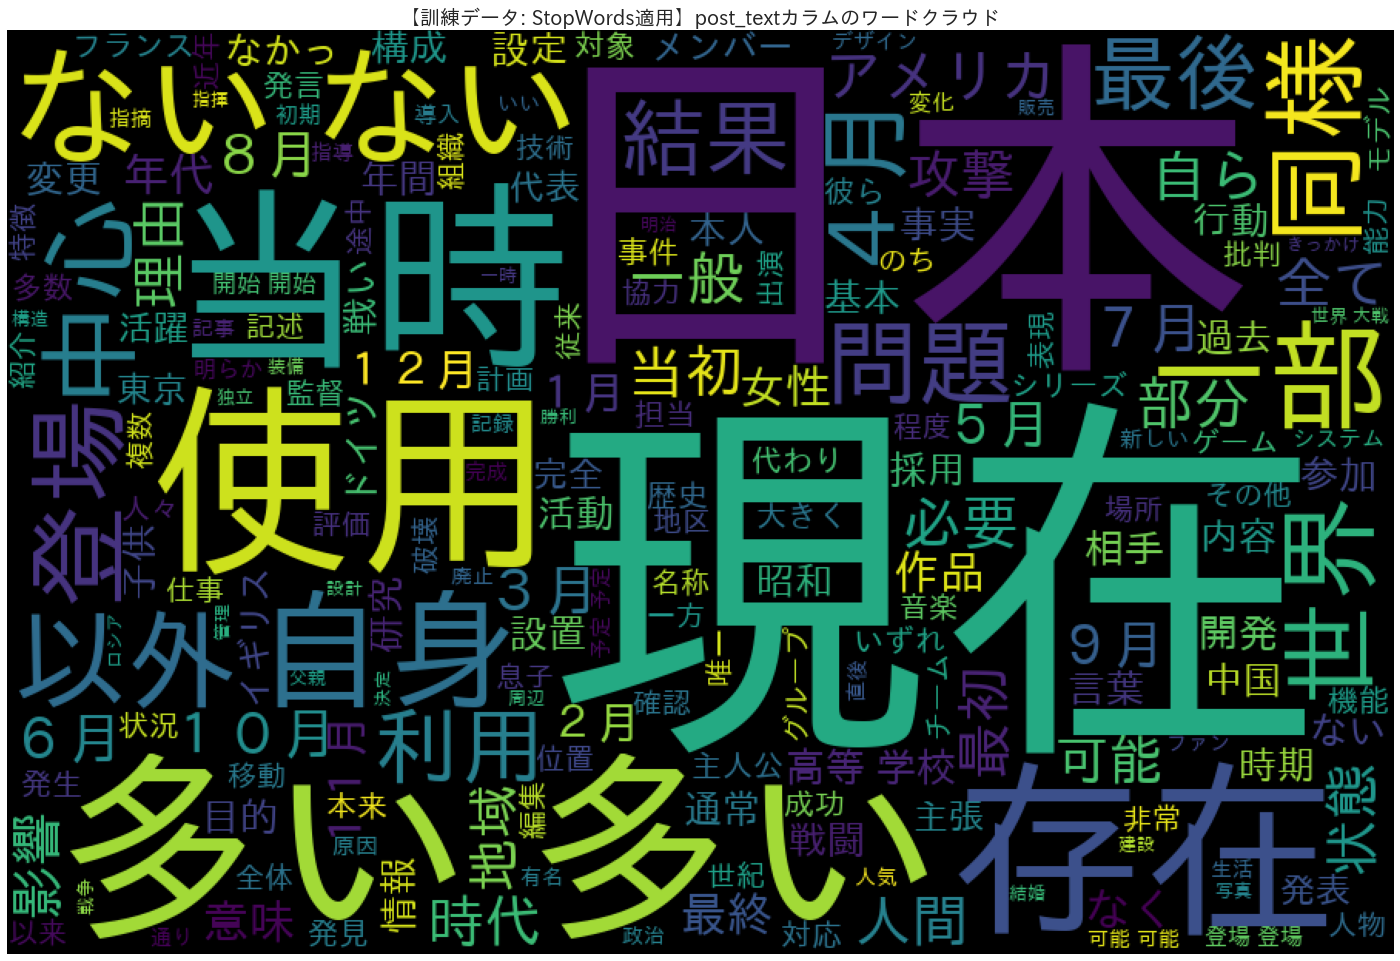

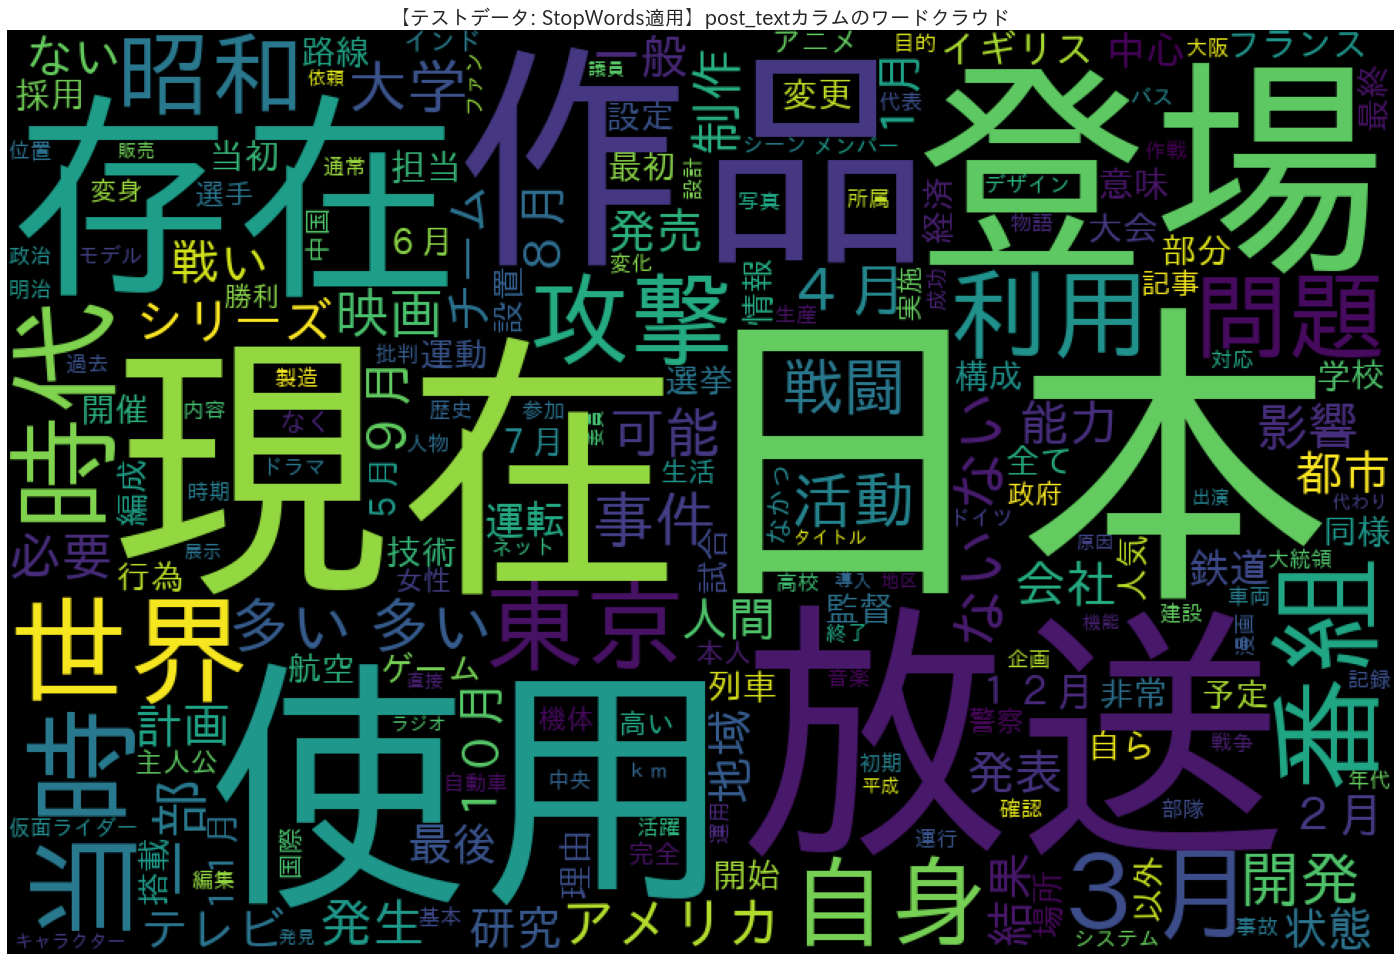

In [ ]:
def word_cloud(series, title):
    japanize_matplotlib.japanize()
    wc = WordCloud(width=900, height=600, font_path=Cfg.font_path) 
    tagger = CustomMeCabTagger(Cfg.extract_feats)
    stopwords = Ja_StopWords(Cfg.stopwords_libpath)
    wc.generate(stopwords.apply_stopwords_string(tagger.parse_to_string(series)))
    plt.figure(figsize=(25,17))
    plt.imshow(wc)
    plt.axis('off')
    plt.title(title, fontdict={'fontsize': 20})

word_cloud(train.post_text, '【訓練データ: StopWords適用】post_textカラムのワードクラウド')
word_cloud(test.post_text, '【テストデータ: StopWords適用】post_textカラムのワードクラウド')

In [ ]:
gc.collect()

24887

### Sentence vectorization

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = BertJapaneseTokenizer.from_pretrained(Cfg.model_name)
model = BertModel.from_pretrained(Cfg.model_name)
model = model.to(device)

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def vectorization(df, tokenizer, model, column='pre_text'):
    le = LabelEncoder()
    labels = le.fit_transform(df['category'].values)
    vecs = []
    for sentence in tqdm(df[column]):
        text_lines = sentence.splitlines()
        texts = '\n'.join(text_lines)
        encoding = tokenizer(texts, 
                             max_length=Cfg.max_length, 
                             padding='max_length', 
                             truncation=True, 
                             return_tensors='pt')
        encoding = {k: v.to(device) for k, v in encoding.items()}
        attention_mask = encoding['attention_mask']
        with torch.no_grad():
            output = model(**encoding)
            last_hidden_state = output.last_hidden_state
            averaged_hidden_state = (last_hidden_state * attention_mask.unsqueeze(-1)).sum(1) / attention_mask.sum(1, keepdim=True)
        vecs.append(averaged_hidden_state[0].cpu().numpy())
    return vecs, labels


tr_pre_vecs, tr_pre_label = vectorization(train, tokenizer, model)
tr_post_vecs, tr_post_label = vectorization(train, tokenizer, model, 'post_text')
te_pre_vecs, te_pre_label = vectorization(test, tokenizer, model)
te_post_vecs, te_post_label = vectorization(test, tokenizer, model, 'post_text')

In [ ]:
np.save('../../vecs/tr_pre_vecs', tr_pre_vecs); np.save('../../vecs/tr_pre_labels', tr_pre_label)
np.save('../../vecs/tr_post_vecs', tr_post_vecs); np.save('../../vecs/tr_post_labels', tr_post_label)
np.save('../../vecs/te_pre_vecs', te_pre_vecs); np.save('../../vecs/te_pre_labels', te_pre_label)
np.save('../../vecs/te_post_vecs', te_post_vecs); np.save('../../vecs/te_post_labels', te_post_label)

tr_pre_vecs = np.load('../../vecs/tr_pre_vecs.npy'); tr_pre_labels = np.load('../../vecs/tr_pre_labels.npy')
tr_post_vecs = np.load('../../vecs/tr_post_vecs.npy'); tr_post_labels = np.load('../../vecs/tr_post_labels.npy')
te_pre_vecs = np.load('../../vecs/te_pre_vecs.npy'); te_pre_labels  = np.load('../../vecs/te_pre_labels.npy')
te_post_vecs = np.load('../../vecs/te_post_vecs.npy'); te_post_labels  = np.load('../../vecs/te_post_labels.npy')

### Dimensionality reduction -> plot

In [ ]:
def train_test_scatter_plot(train_vectors, test_vectors, title):
    plt.style.use('seaborn')
    japanize_matplotlib.japanize()
    fig = plt.figure(figsize=(12,12))
    plt.scatter(train_vectors[:,0], train_vectors[:,1], 
                alpha=0.5, linewidths=2, color='#aaaaFF', 
                edgecolors='b', label='訓練データ')
    plt.scatter(test_vectors[:,0], test_vectors[:,1], 
                alpha=0.5, linewidths=2, color='#FFaaaa', 
                edgecolors='r', label='テストデータ')
    plt.title(title, fontsize=18)
    plt.legend(bbox_to_anchor=(1.05, 1), fontsize=18)


def categorical_scatter_plot(vectors, labels, overall_title):
    plt.style.use('seaborn')
    japanize_matplotlib.japanize()
    fig = plt.figure(figsize=(12,12))
    for label in range(len(Cfg.categories)):
        plt.subplot(3, 3, label+1)
        index = labels == label
        plt.plot(vectors[:,0], vectors[:,1], 'o', markersize=1, color='limegreen')
        plt.plot(vectors[index,0], vectors[index,1], 'o', markersize=2, color='b')
        plt.title(Cfg.categories[label])
        fig.suptitle(overall_title, size=20)
        if label == 2:
            # dummy
            plt.scatter([], [], color='limegreen', label='データ全件')
            plt.scatter([], [], color='b', label='カテゴリ別データ') 
            plt.legend(bbox_to_anchor=(1.05, 1), fontsize=18)

In [ ]:
tr_pre_vecs_pca = PCA(n_components=2, random_state=Cfg.seed).fit_transform(tr_pre_vecs)
tr_post_vecs_pca = PCA(n_components=2, random_state=Cfg.seed).fit_transform(tr_post_vecs)
te_pre_vecs_pca = PCA(n_components=2, random_state=Cfg.seed).fit_transform(te_pre_vecs)
te_post_vecs_pca = PCA(n_components=2, random_state=Cfg.seed).fit_transform(te_post_vecs)

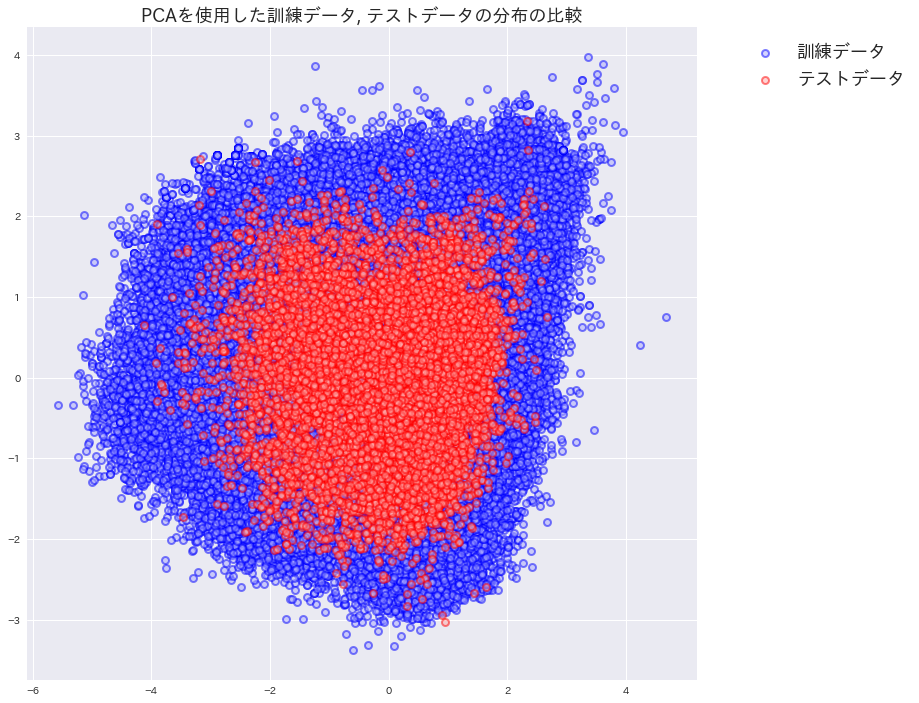

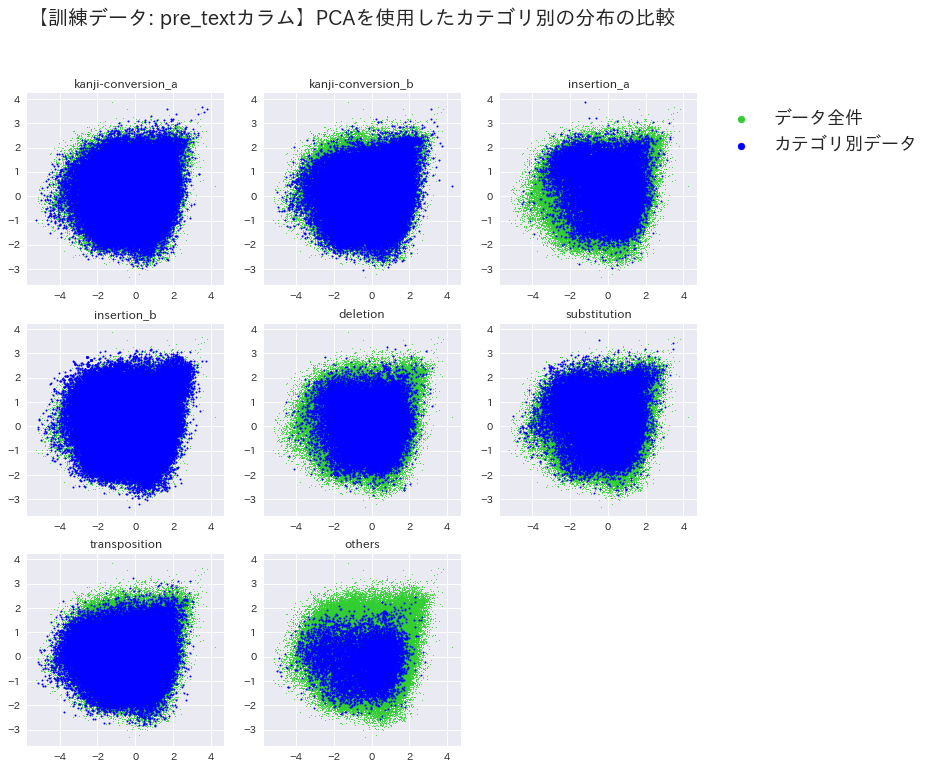

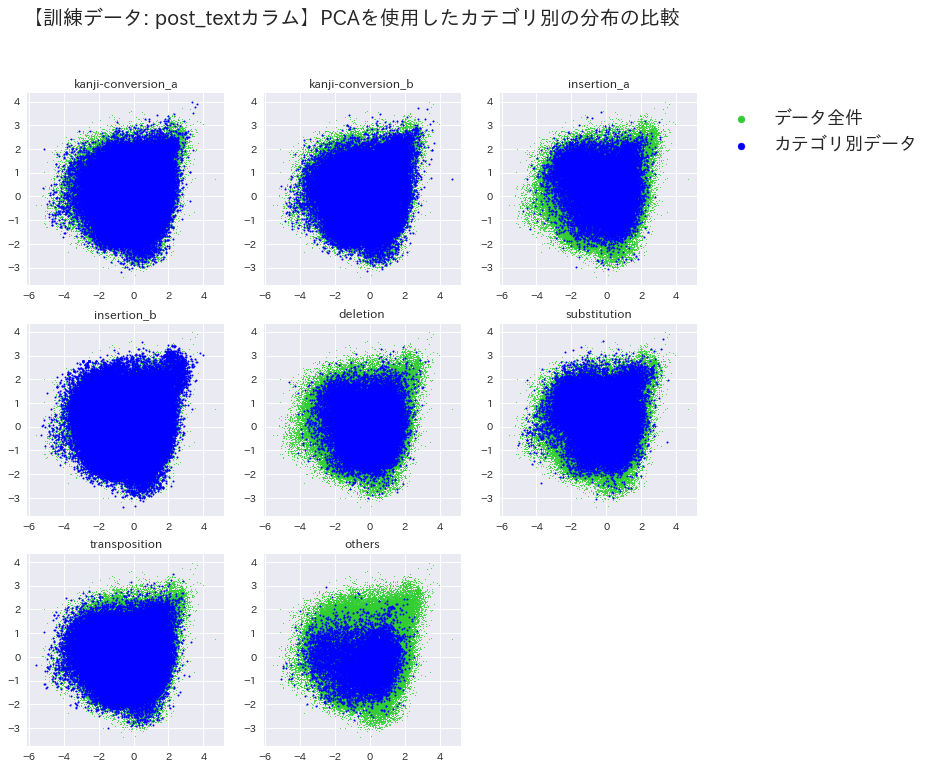

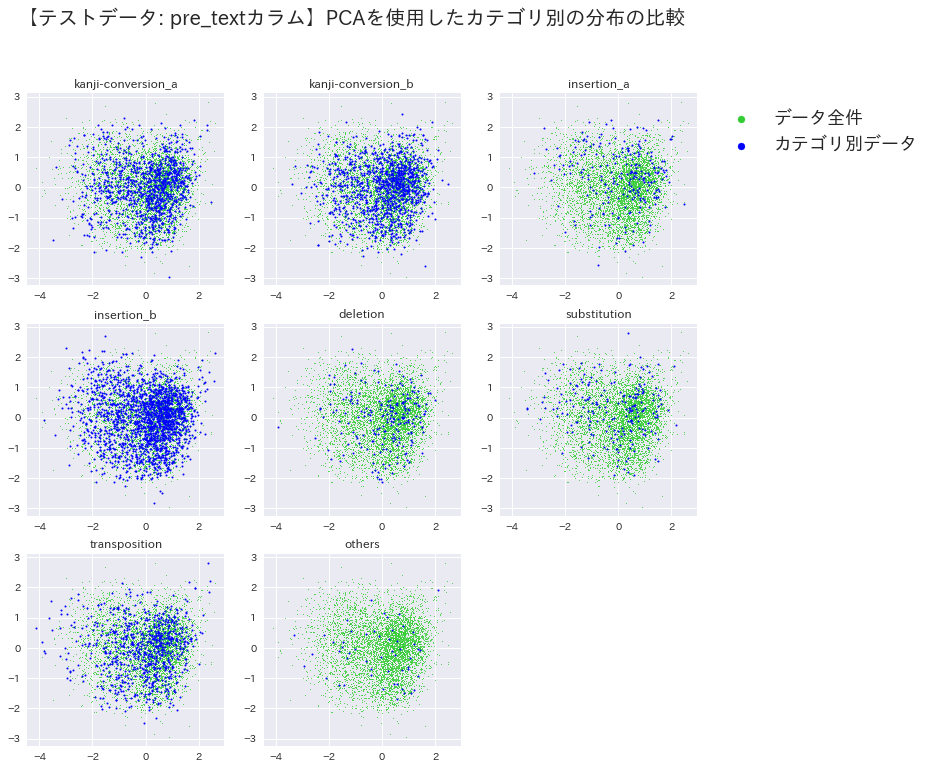

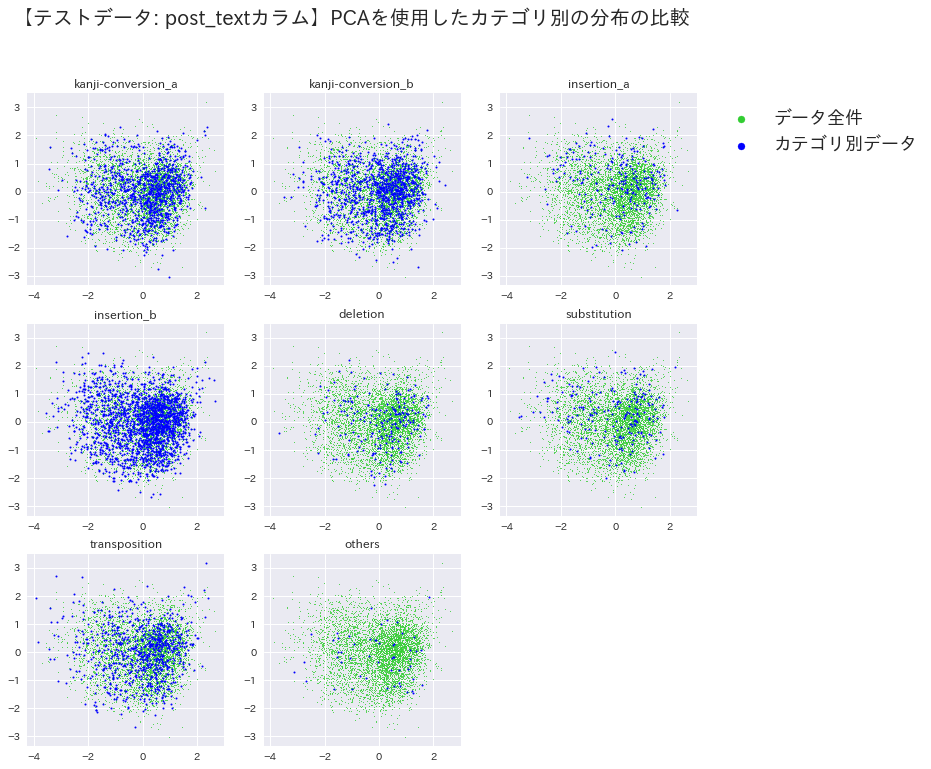

In [ ]:
train_test_scatter_plot(
    np.concatenate([tr_pre_vecs_pca,tr_post_vecs_pca]), 
    np.concatenate([te_pre_vecs_pca,te_post_vecs_pca]), 
    'PCAを使用した訓練データ, テストデータの分布の比較'
    )
categorical_scatter_plot(tr_pre_vecs_pca, tr_pre_labels, '【訓練データ: pre_textカラム】PCAを使用したカテゴリ別の分布の比較')
categorical_scatter_plot(tr_post_vecs_pca, tr_post_labels, '【訓練データ: post_textカラム】PCAを使用したカテゴリ別の分布の比較')
categorical_scatter_plot(te_pre_vecs_pca, te_pre_labels, '【テストデータ: pre_textカラム】PCAを使用したカテゴリ別の分布の比較')
categorical_scatter_plot(te_post_vecs_pca, te_post_labels, '【テストデータ: post_textカラム】PCAを使用したカテゴリ別の分布の比較')

In [ ]:
tr_pre_vecs_tsne = TSNE(n_components=2, random_state=Cfg.seed).fit_transform(tr_pre_vecs)
tr_post_vecs_tsne = TSNE(n_components=2, random_state=Cfg.seed).fit_transform(tr_post_vecs)
te_pre_vecs_tsne = TSNE(n_components=2, random_state=Cfg.seed).fit_transform(te_pre_vecs)
te_post_vecs_tsne = TSNE(n_components=2, random_state=Cfg.seed).fit_transform(te_post_vecs)

[W] [09:49:48.227282] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
[W] [09:54:06.906884] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


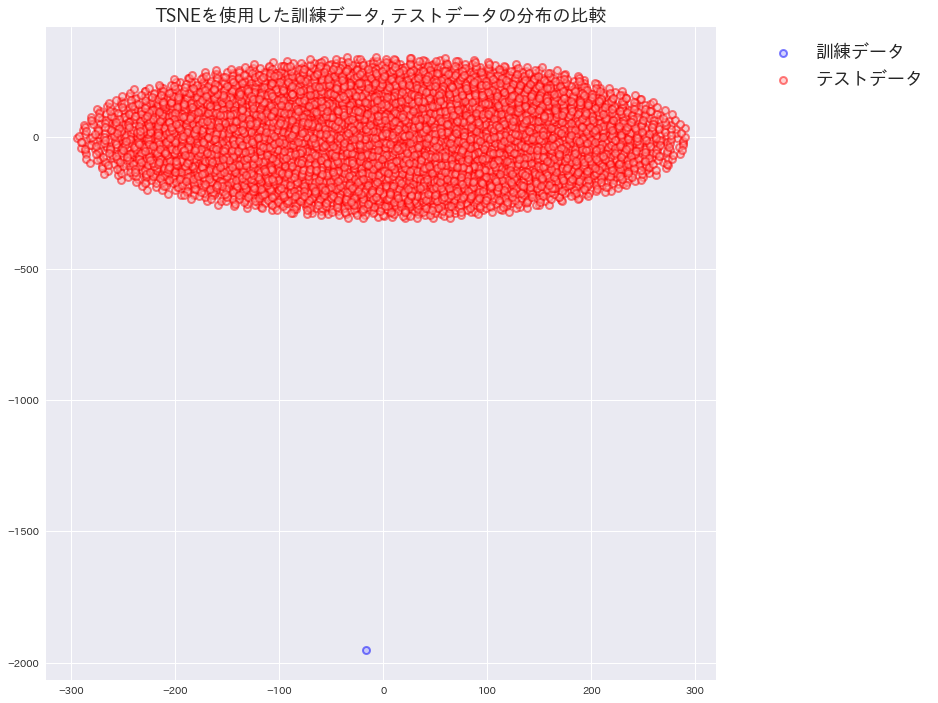

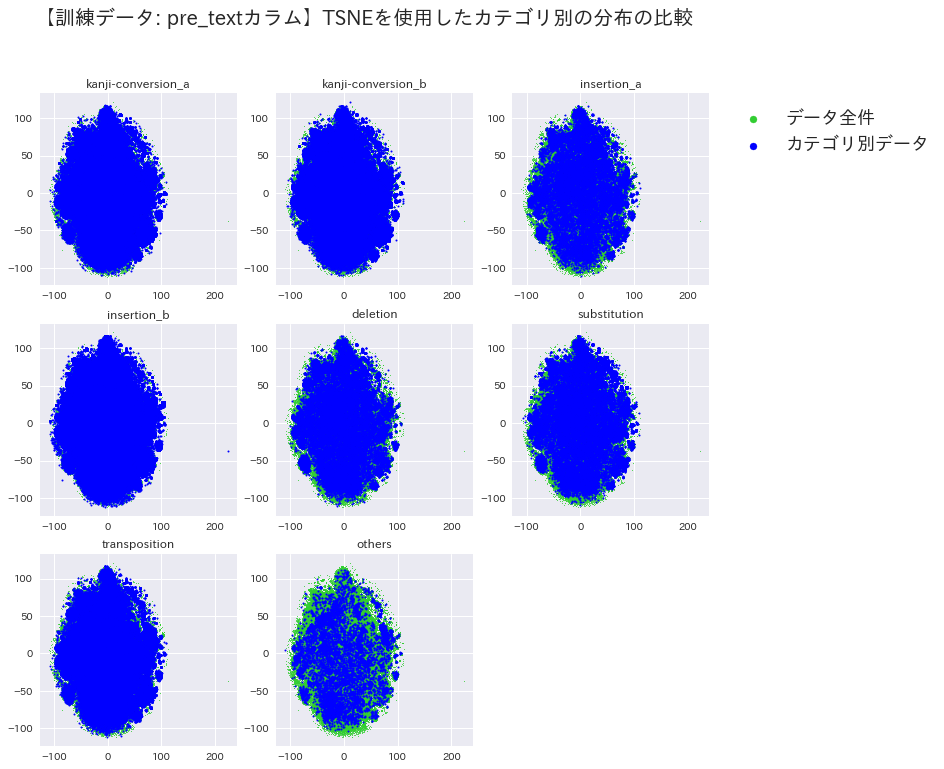

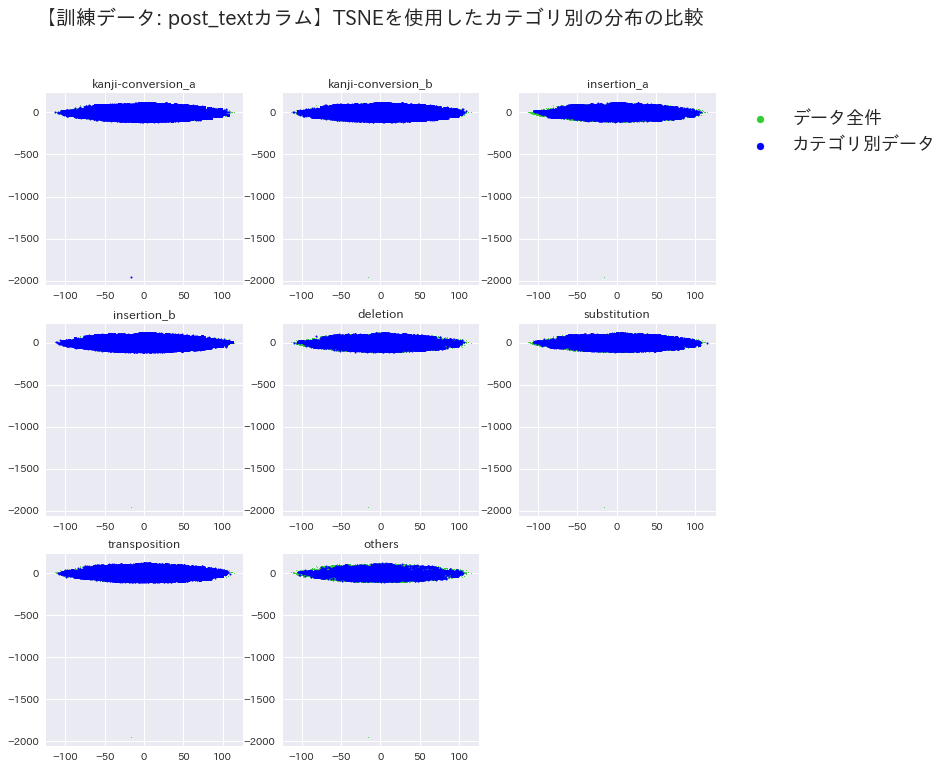

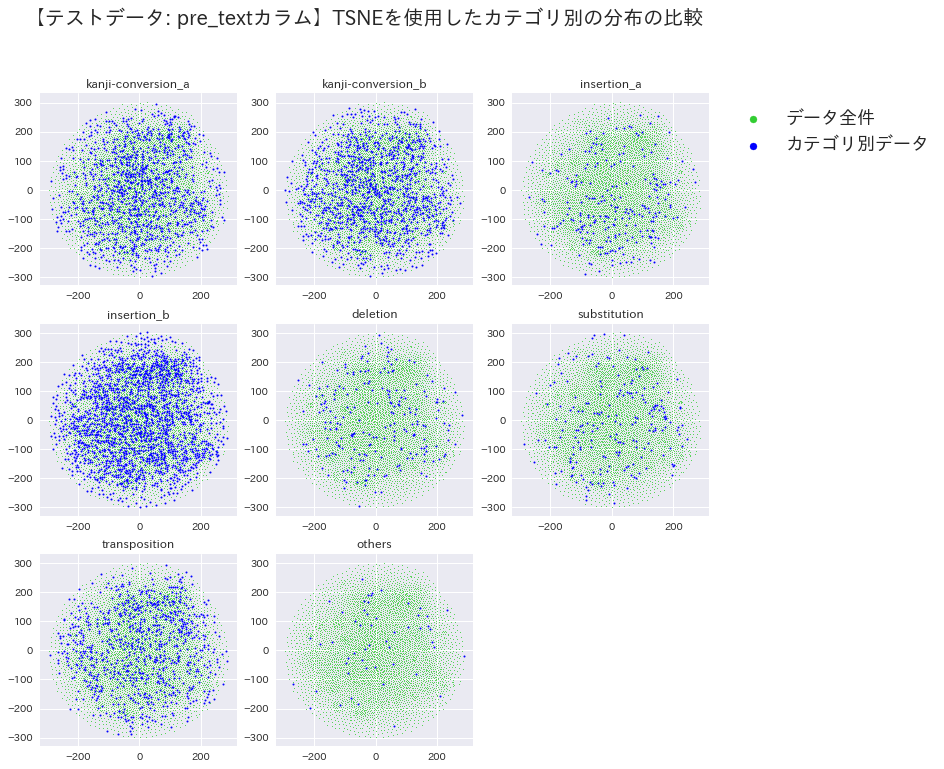

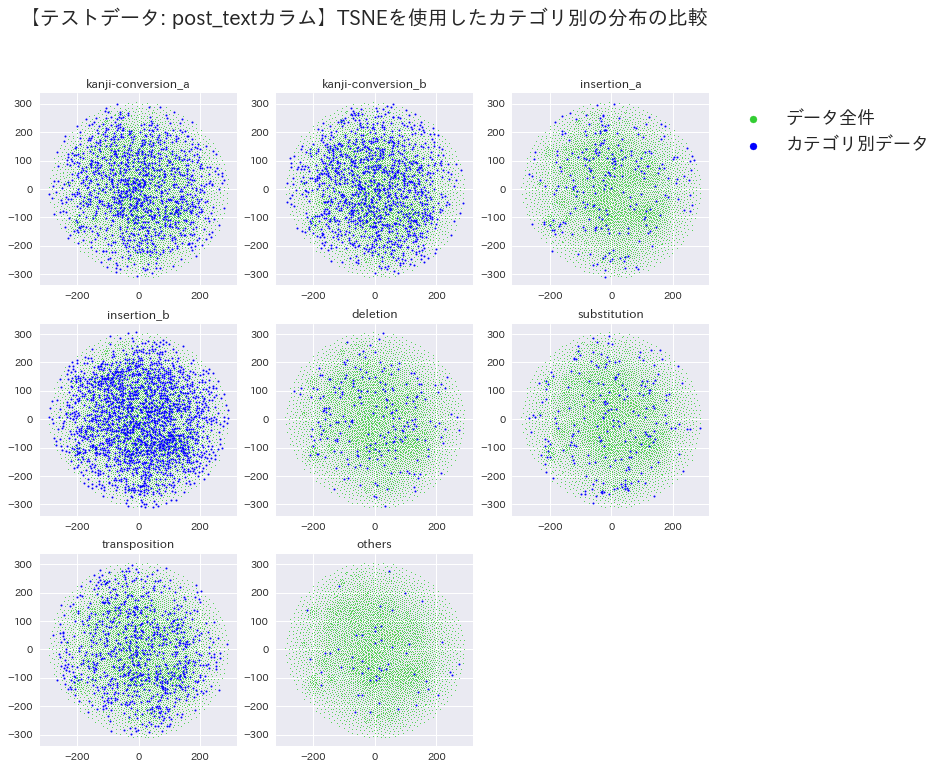

In [ ]:
train_test_scatter_plot(
    np.concatenate([tr_pre_vecs_tsne,tr_post_vecs_tsne]), 
    np.concatenate([te_pre_vecs_tsne,te_post_vecs_tsne]), 
    'TSNEを使用した訓練データ, テストデータの分布の比較'
    )
categorical_scatter_plot(tr_pre_vecs_tsne, tr_pre_labels, '【訓練データ: pre_textカラム】TSNEを使用したカテゴリ別の分布の比較')
categorical_scatter_plot(tr_post_vecs_tsne, tr_post_labels, '【訓練データ: post_textカラム】TSNEを使用したカテゴリ別の分布の比較')
categorical_scatter_plot(te_pre_vecs_tsne, te_pre_labels, '【テストデータ: pre_textカラム】TSNEを使用したカテゴリ別の分布の比較')
categorical_scatter_plot(te_post_vecs_tsne, te_post_labels, '【テストデータ: post_textカラム】TSNEを使用したカテゴリ別の分布の比較')

In [ ]:
tr_pre_vecs_umap = UMAP(n_components=2, n_neighbors=5, random_state=Cfg.seed).fit_transform(tr_pre_vecs)
tr_post_vecs_umap = UMAP(n_components=2, n_neighbors=5, random_state=Cfg.seed).fit_transform(tr_post_vecs)
te_pre_vecs_umap = UMAP(n_components=2, n_neighbors=5, random_state=Cfg.seed).fit_transform(te_pre_vecs)
te_post_vecs_umap = UMAP(n_components=2, n_neighbors=5, random_state=Cfg.seed).fit_transform(te_post_vecs)

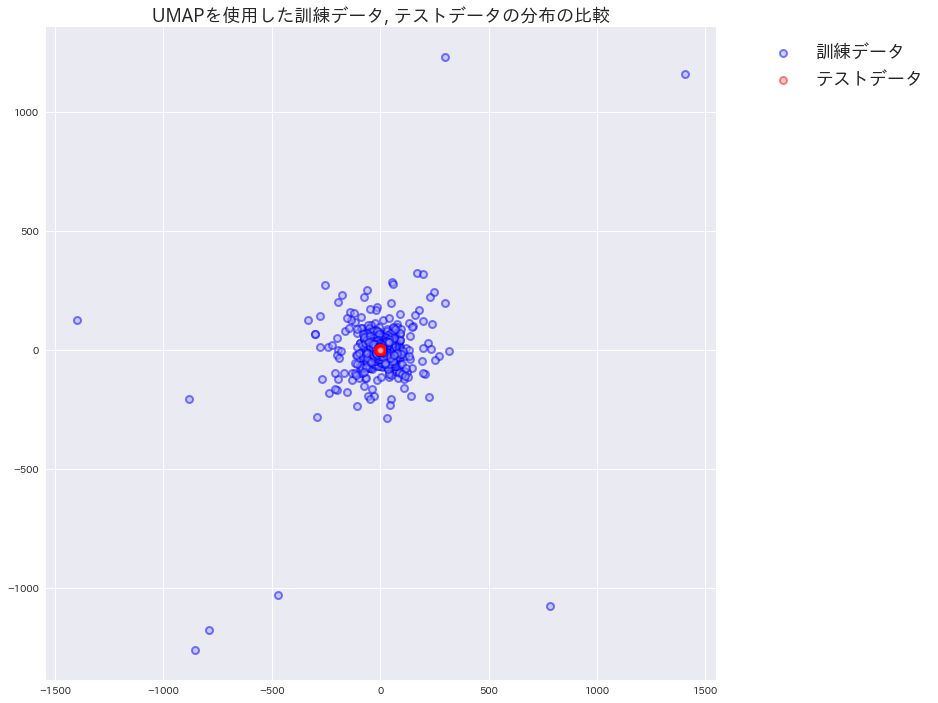

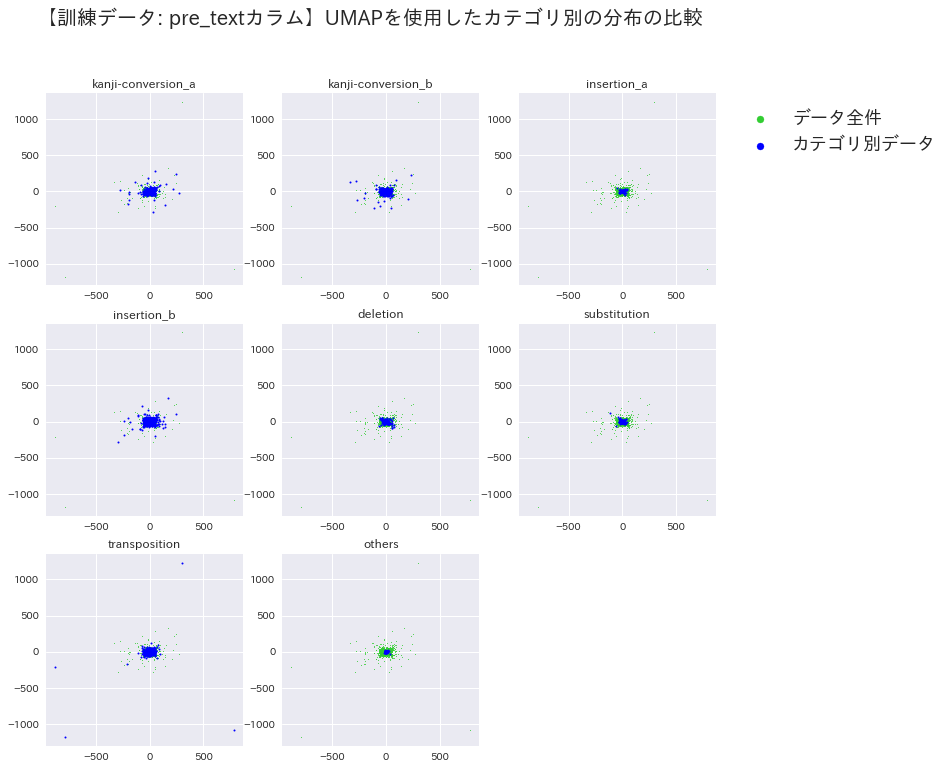

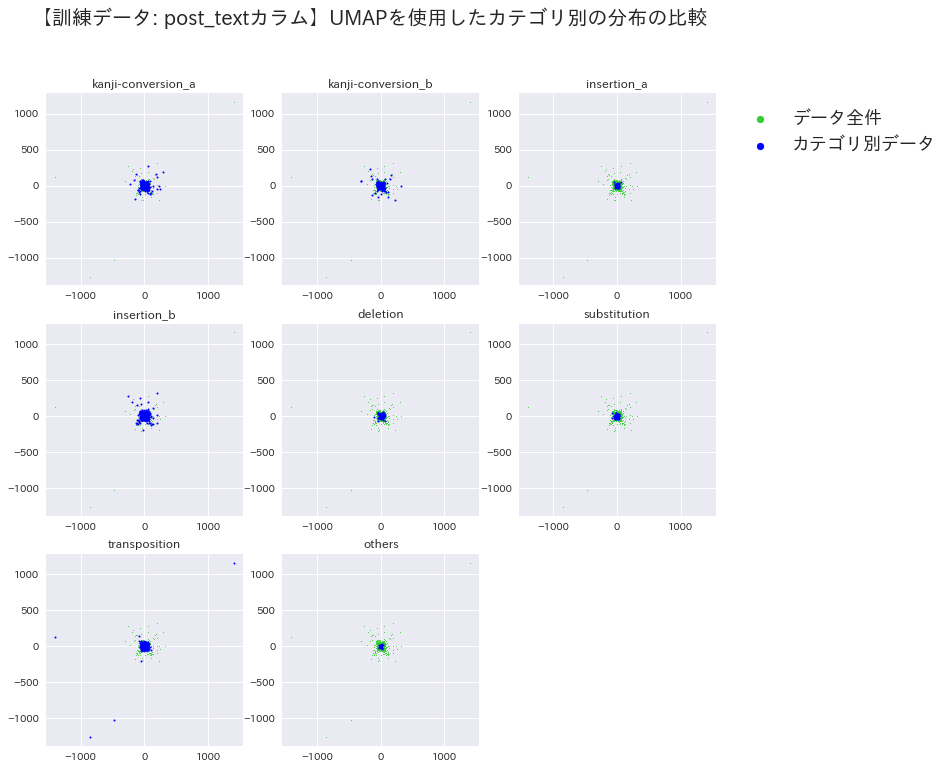

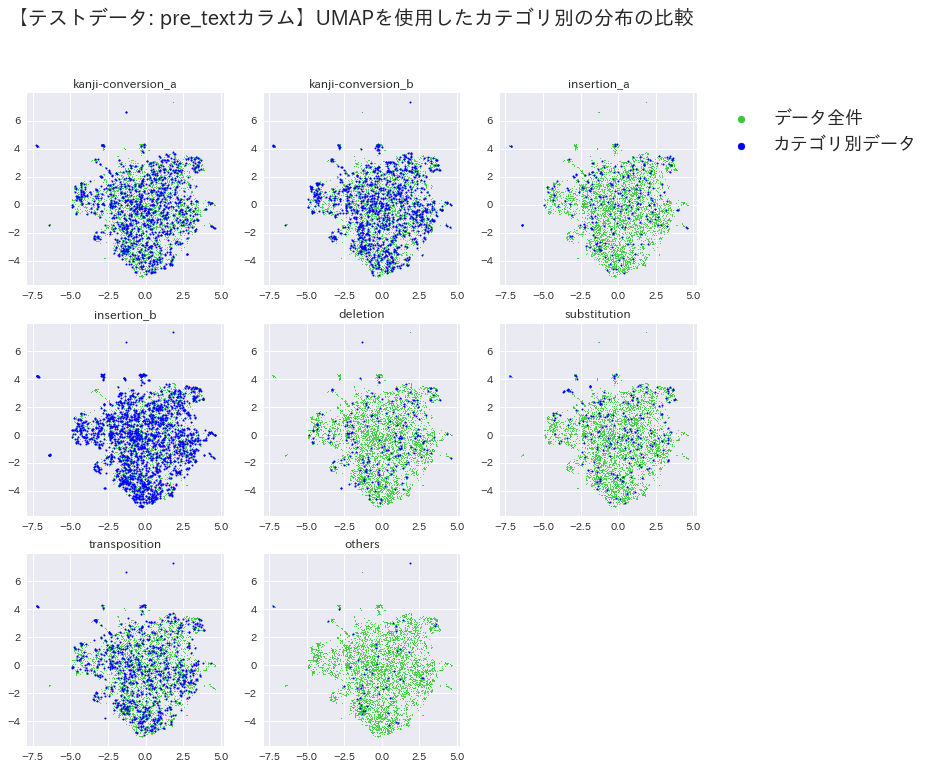

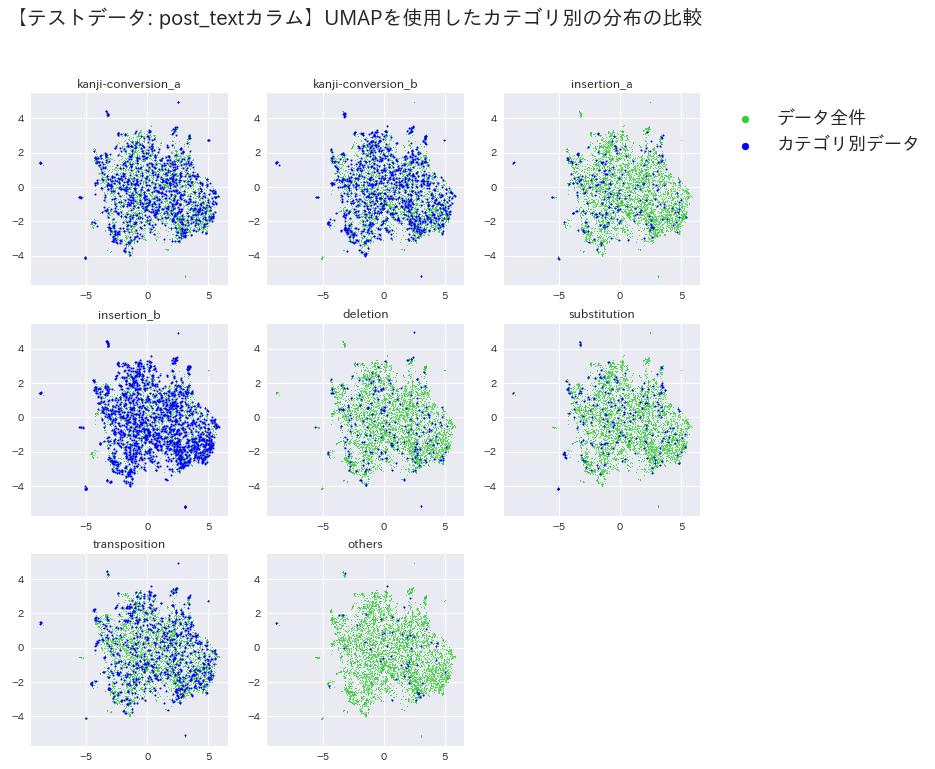

In [ ]:
train_test_scatter_plot(
    np.concatenate([tr_pre_vecs_umap,tr_post_vecs_umap]), 
    np.concatenate([te_pre_vecs_umap,te_post_vecs_umap]), 
    'UMAPを使用した訓練データ, テストデータの分布の比較'
    )
categorical_scatter_plot(tr_pre_vecs_umap, tr_pre_labels, '【訓練データ: pre_textカラム】UMAPを使用したカテゴリ別の分布の比較')
categorical_scatter_plot(tr_post_vecs_umap, tr_post_labels, '【訓練データ: post_textカラム】UMAPを使用したカテゴリ別の分布の比較')
categorical_scatter_plot(te_pre_vecs_umap, te_pre_labels, '【テストデータ: pre_textカラム】UMAPを使用したカテゴリ別の分布の比較')
categorical_scatter_plot(te_post_vecs_umap, te_post_labels, '【テストデータ: post_textカラム】UMAPを使用したカテゴリ別の分布の比較')

In [ ]:
tr_pre_vecs_pca = PCA(n_components=50, random_state=Cfg.seed).fit_transform(tr_pre_vecs)
tr_post_vecs_pca = PCA(n_components=50, random_state=Cfg.seed).fit_transform(tr_post_vecs)
te_pre_vecs_pca = PCA(n_components=50, random_state=Cfg.seed).fit_transform(te_pre_vecs)
te_post_vecs_pca = PCA(n_components=50, random_state=Cfg.seed).fit_transform(te_post_vecs)

tr_pre_vecs_pca_umap = UMAP(n_components=2, n_neighbors=5, random_state=Cfg.seed).fit_transform(tr_pre_vecs_pca)
tr_post_vecs_pca_umap = UMAP(n_components=2, n_neighbors=5, random_state=Cfg.seed).fit_transform(tr_post_vecs_pca)
te_pre_vecs_pca_umap = UMAP(n_components=2, n_neighbors=5, random_state=Cfg.seed).fit_transform(te_pre_vecs_pca)
te_post_vecs_pca_umap = UMAP(n_components=2, n_neighbors=5, random_state=Cfg.seed).fit_transform(te_post_vecs_pca)

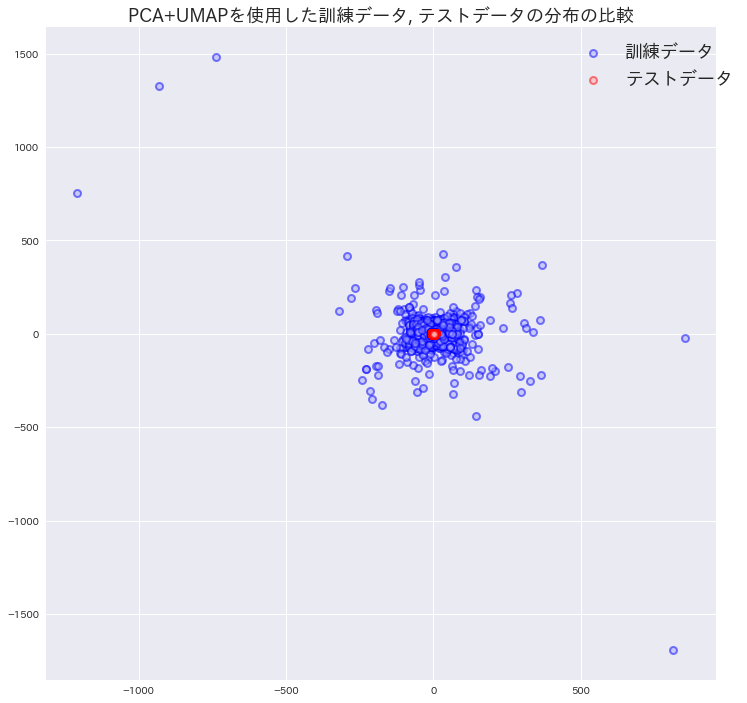

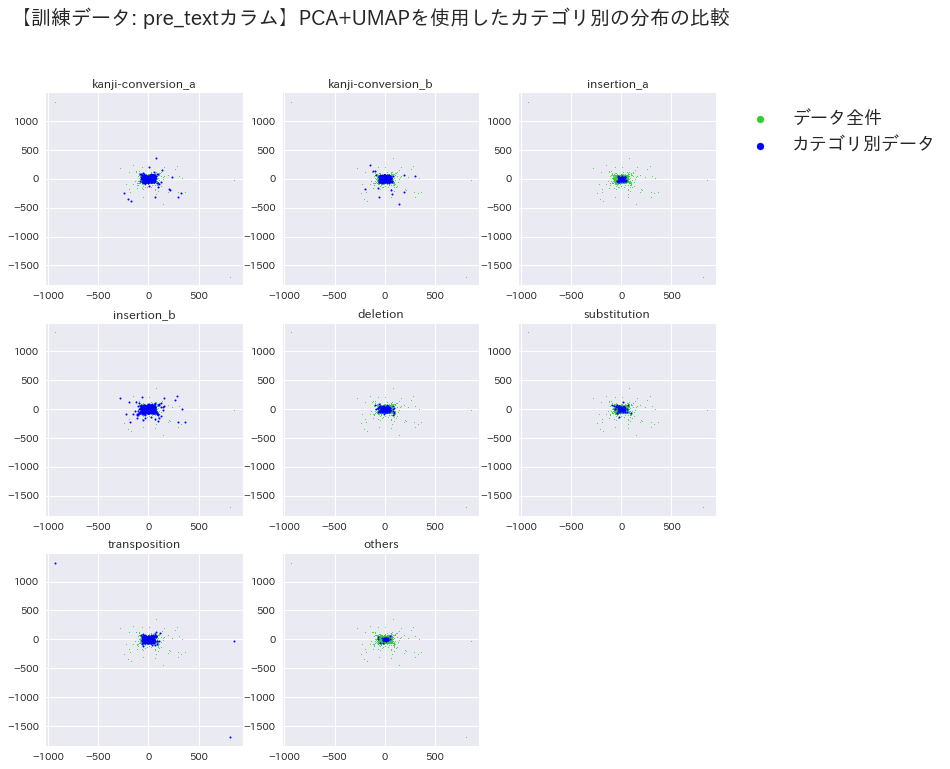

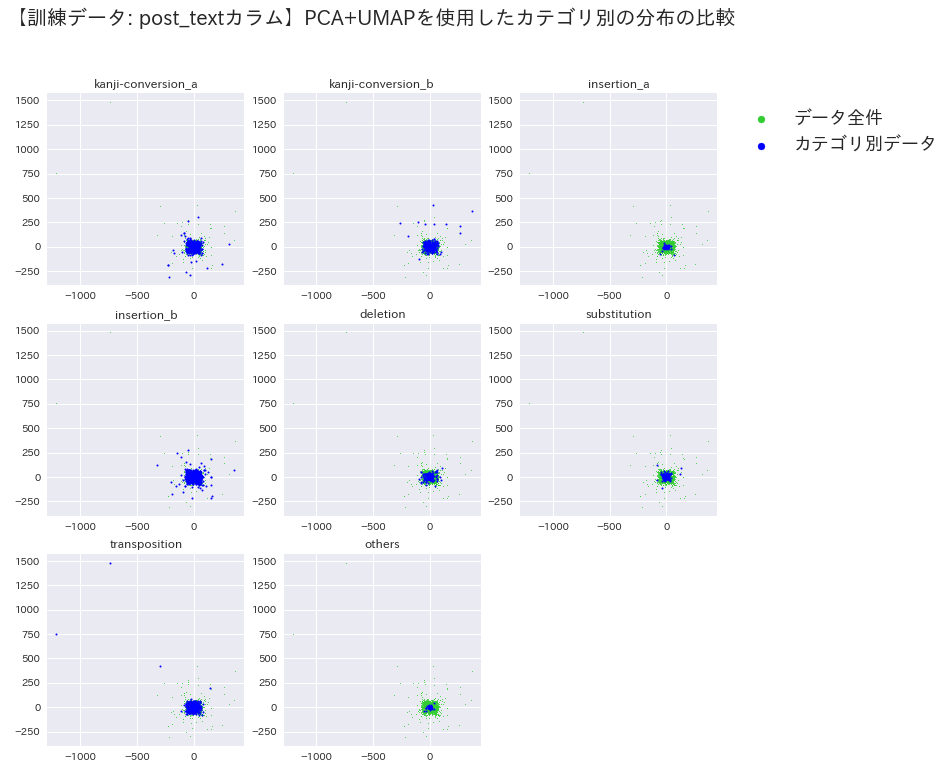

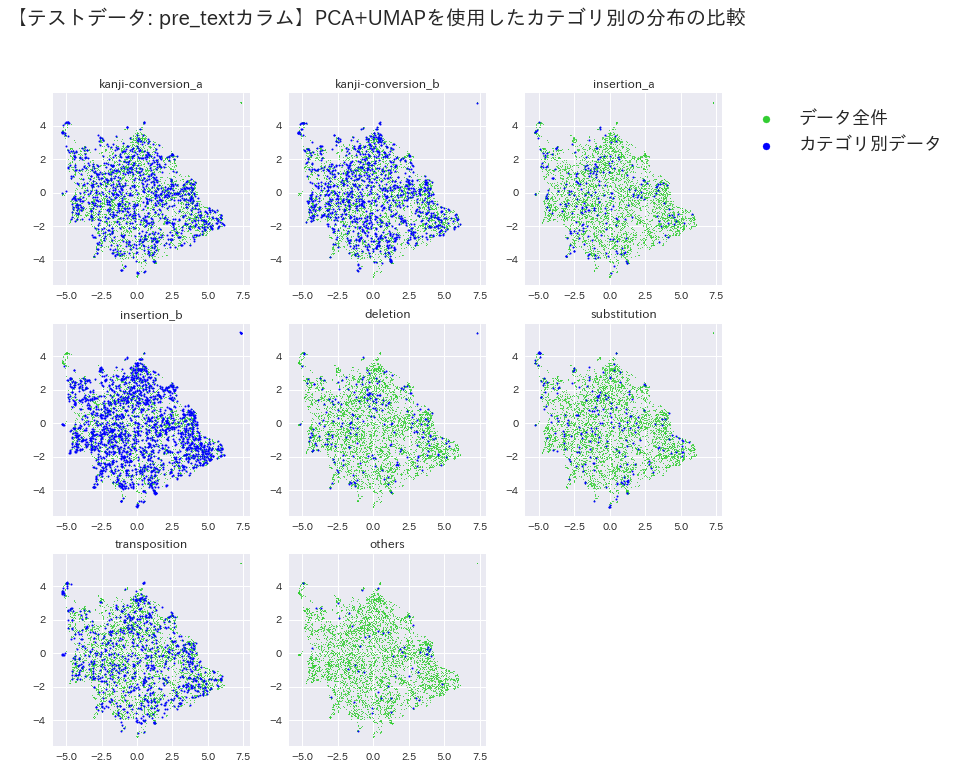

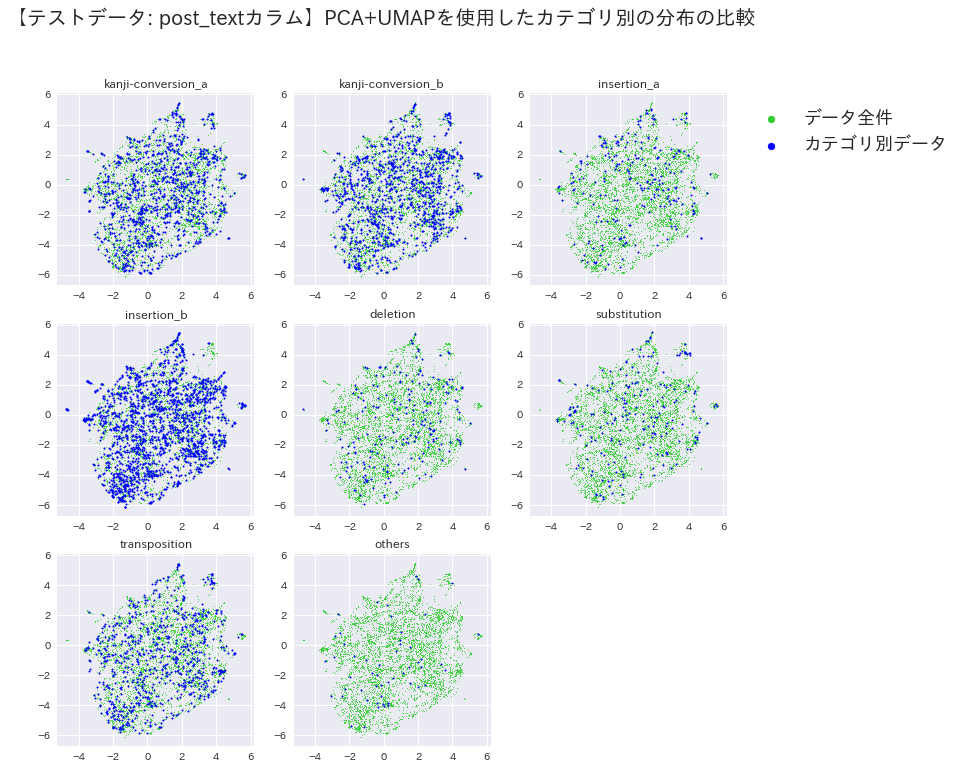

In [ ]:
train_test_scatter_plot(
    np.concatenate([tr_pre_vecs_pca_umap,tr_post_vecs_pca_umap]), 
    np.concatenate([te_pre_vecs_pca_umap,te_post_vecs_pca_umap]), 
    'PCA+UMAPを使用した訓練データ, テストデータの分布の比較'
    )
categorical_scatter_plot(tr_pre_vecs_pca_umap, tr_pre_labels, '【訓練データ: pre_textカラム】PCA+UMAPを使用したカテゴリ別の分布の比較')
categorical_scatter_plot(tr_post_vecs_pca_umap, tr_post_labels, '【訓練データ: post_textカラム】PCA+UMAPを使用したカテゴリ別の分布の比較')
categorical_scatter_plot(te_pre_vecs_pca_umap, te_pre_labels, '【テストデータ: pre_textカラム】PCA+UMAPを使用したカテゴリ別の分布の比較')
categorical_scatter_plot(te_post_vecs_pca_umap, te_post_labels, '【テストデータ: post_textカラム】PCA+UMAPを使用したカテゴリ別の分布の比較')

## Preprocess

In [ ]:
def text_normalize(text):
    text = text.strip()
    text = unicodedata.normalize('NFKC', text)
    return text

def text_preprocess(df):
    df = df.query('category in @Cfg.categories')
    df = df[['pre_text','post_text','category']]
    df['pre_text'] = df['pre_text'].map(text_normalize)
    df['post_text'] = df['post_text'].map(text_normalize)
    return df

train = text_preprocess(train)
test = text_preprocess(test)

In [ ]:
# pre_textとpost_textが完全一致しているデータは
# 学習及び、検証への悪影響が懸念されるため、取り除く

def str_comparison(pred, target):
    if pred == target:
        return True
    else:
        return False

def apply_strComparison(df):
    df['match'] = [str_comparison(sample['pre_text'],sample['post_text']) for sample in df.to_dict(orient='records')]
    return df

train = apply_strComparison(train)

In [ ]:
print(f'カテゴリ別訓練データの完全一致の件数: \n{train.query("match == True").category.value_counts()}')

カテゴリ別訓練データの完全一致の件数: 
others                32
kanji-conversion_b     9
substitution           8
kanji-conversion_a     7
insertion_a            1
Name: category, dtype: int64


In [ ]:
train = train.query('match != True')

In [ ]:
print(f'カテゴリ別訓練データの件数: \n{train.category.value_counts()}\n')
print(f'カテゴリ別テストデータの件数: \n{test.category.value_counts()}')

カテゴリ別訓練データの件数: 
kanji-conversion_a    255940
deletion              133344
insertion_a           114085
substitution          100587
others                 32507
kanji-conversion_b     27518
insertion_b            23126
transposition           9025
Name: category, dtype: int64

カテゴリ別テストデータの件数: 
kanji-conversion_a    1832
insertion_a           1091
deletion              1038
substitution           779
insertion_b            231
kanji-conversion_b     211
others                 205
transposition           53
Name: category, dtype: int64


## Export

In [ ]:
# train及び、testをカテゴリ別に分けてエクスポート
def df_to_csv(df, test_data=False):
    for category in Cfg.extract_categories:
        if isinstance(category, list):
            ext_df = df[df['category'].isin(category)]
            if test_data:
                ext_df.to_csv(f'test_{category[0][:-2]}.csv', index=False)
            else:
                ext_df.to_csv(f'train_{category[0][:-2]}.csv', index=False)
        else:
            ext_df = df.query('category == @category')
            if test_data:
                ext_df.to_csv(f'test_{category}.csv', index=False)
            else:
                ext_df.to_csv(f'train_{category}.csv', index=False)

In [ ]:
df_to_csv(train)
df_to_csv(test, test_data=True)